# Support_Vector_Machine_Regression

## I. Chuẩn bị dữ liệu

Trong phần này, bài toán được xây dựng dưới dạng hồi quy, với mục tiêu dự đoán thu nhập hàng tháng (MonthlyIncome) của nhân viên dựa trên các đặc trưng nhân sự và công việc.

MonthlyIncome là một biến liên tục, nó đại diện cho thu nhập hàng tháng của nhân viên dựa vào các dữ liệu được thu thập trước đó, đây là biến liên tục và phù hợp với bài toán hồi quy.

In [1]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
import pandas as pd
import numpy as np

df = pd.read_csv('../Dataset/archive/WA_Fn-UseC_-HR-Employee-Attrition.csv')

X = df.drop(['Attrition', 'MonthlyIncome', 'EmployeeNumber', 'Over18', 'EmployeeCount', 'StandardHours'], axis=1)
y = df['MonthlyIncome']

col_int32 = ['DailyRate', 'MonthlyRate']
col_int16 = ['Age', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'HourlyRate', 
             'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'NumCompaniesWorked', 
             'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 
             'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 
             'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 
             'YearsSinceLastPromotion', 'YearsWithCurrManager']

# ép kiểu
X[col_int32] = X[col_int32].astype('int32')
X[col_int16] = X[col_int16].astype('int16')
y = y.astype('int32')

X_origin = X.copy()
y_origin = y.copy()

# One-hot cho các cột nominal
one_hot_encoder = OneHotEncoder(
    sparse_output=False,
    handle_unknown='ignore',
    drop='first'
)

encode_cols = [
    'BusinessTravel', 'Department', 'EducationField',
    'Gender', 'JobRole', 'MaritalStatus', 'OverTime'
]

X_encoded_array = one_hot_encoder.fit_transform(X_origin[encode_cols])
encoded_columns = one_hot_encoder.get_feature_names_out(encode_cols)

X_encoded_df = pd.DataFrame(
    X_encoded_array, 
    columns=encoded_columns,
    index=X_origin.index
)

# Gộp data sau one-hot
X_encode = pd.concat([X_origin.drop(columns=encode_cols), X_encoded_df], axis=1)

# One-hot columns cũng ép về float32
one_hot_cols = X_encoded_df.columns
X_encode[one_hot_cols] = X_encode[one_hot_cols].astype('float32')


In [2]:
X_encode.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 43 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                1470 non-null   int16  
 1   DailyRate                          1470 non-null   int32  
 2   DistanceFromHome                   1470 non-null   int16  
 3   Education                          1470 non-null   int16  
 4   EnvironmentSatisfaction            1470 non-null   int16  
 5   HourlyRate                         1470 non-null   int16  
 6   JobInvolvement                     1470 non-null   int16  
 7   JobLevel                           1470 non-null   int16  
 8   JobSatisfaction                    1470 non-null   int16  
 9   MonthlyRate                        1470 non-null   int32  
 10  NumCompaniesWorked                 1470 non-null   int16  
 11  PercentSalaryHike                  1470 non-null   int16

In [3]:
y_origin.info()

<class 'pandas.core.series.Series'>
RangeIndex: 1470 entries, 0 to 1469
Series name: MonthlyIncome
Non-Null Count  Dtype
--------------  -----
1470 non-null   int32
dtypes: int32(1)
memory usage: 5.9 KB


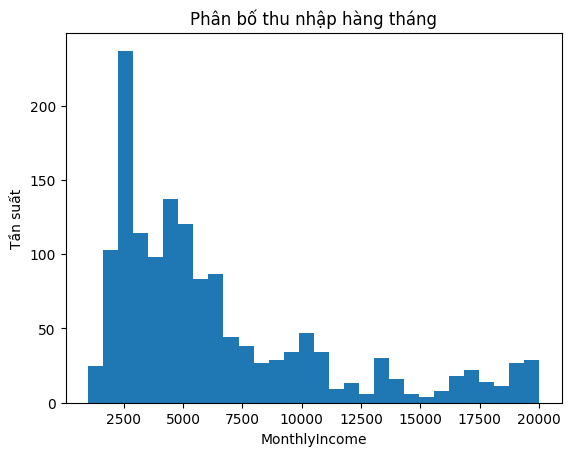

In [4]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(y_origin, bins=30)
plt.xlabel('MonthlyIncome')
plt.ylabel('Tần suất')
plt.title('Phân bố thu nhập hàng tháng')
plt.show()

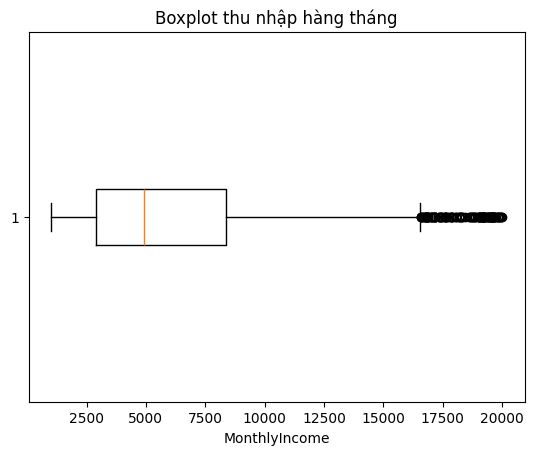

In [5]:
plt.figure()
plt.boxplot(y_origin, vert=False)
plt.xlabel('MonthlyIncome')
plt.title('Boxplot thu nhập hàng tháng')
plt.show()


## II.Định nghĩa Class, Function hỗ trợ

In [6]:
# Khai báo các danh sách tham số
KERNELS = ['linear', 'poly', 'rbf']
C_LIST = [10, 100, 1000]
EPSILONS = [0.1, 1, 10]
TEST_SIZES = [0.2, 0.3]

In [7]:
def plot_true_vs_pred_line(
    y_true,
    y_pred,
    bins=50,
    title="So sánh phân bố y thực và y dự đoán"
):
    import numpy as np
    import matplotlib.pyplot as plt
    
    counts_true, bin_edges = np.histogram(y_true, bins=bins)
    counts_pred, _ = np.histogram(y_pred, bins=bin_edges)
    centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.plot(centers, counts_true, label="Giá trị thực", linewidth=2)
    plt.plot(centers, counts_pred, label="Giá trị dự đoán", linestyle="--", linewidth=2)

    plt.xlabel("Giá trị")
    plt.ylabel("Tần suất")
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

def validate_svr(X=None, y=None, std=True, reduce=False):
    continuous_data = [
        'DailyRate', 'MonthlyRate', 'Age', 'DistanceFromHome', 'Education', 
        'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 
        'JobSatisfaction', 'NumCompaniesWorked', 'PercentSalaryHike', 
        'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 
        'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 
        'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 
        'YearsWithCurrManager'
    ]
    
    results = []

    for kernel in KERNELS:
        for C in C_LIST:
            for epsilon in EPSILONS:
                for test_size in TEST_SIZES:
                    
                    X_train, X_test, y_train, y_test = train_test_split(
                        X, y, test_size=test_size, random_state=42
                    )

                    if std:
                        scaler = StandardScaler()
                        X_train_scaled = X_train.copy()
                        X_test_scaled = X_test.copy()
                        
                        X_train_scaled[continuous_data] = scaler.fit_transform(X_train[continuous_data])
                        X_test_scaled[continuous_data] = scaler.transform(X_test[continuous_data])
                    else:
                        X_train_scaled, X_test_scaled = X_train, X_test

                    if reduce:
                        model_rd = PCA(n_components=14)
                        X_train_scaled = model_rd.fit_transform(X_train_scaled)
                        X_test_scaled = model_rd.transform(X_test_scaled)    

                    model = SVR(
                        kernel=kernel, 
                        C=C, 
                        epsilon=epsilon,
                        gamma='scale'
                    )
                    model.fit(X_train_scaled, y_train)
                    
                    # 4. Dự báo và đánh giá
                    y_pred = model.predict(X_test_scaled)

                    mae = mean_absolute_error(y_test, y_pred)
                    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                    r2 = r2_score(y_test, y_pred)

                    # Lưu kết quả
                    results.append({
                        "Kernel": kernel,
                        "C": C,
                        "Epsilon": epsilon,
                        "Test_Size": test_size,
                        "MAE": mae,
                        "RMSE": rmse,
                        "R2": r2
                    })

                    # In kết quả kiểm thử
                    print("-" * 60)
                    print(f"SVR Config: Kernel={kernel}, C={C}, Eps={epsilon}, Test={test_size}")
                    print(f"Results: RMSE={rmse:.2f}, R2={r2:.3f}")
                    
                    plot_true_vs_pred_line(y_test, y_pred)

    return results

## III.Dự đoán với mô hình

### Thực hiện với dữ liệu đã mã hóa onehot và chuẩn hóa

------------------------------------------------------------
SVR Config: Kernel=linear, C=10, Eps=0.1, Test=0.2
Results: RMSE=1554.97, R2=0.889


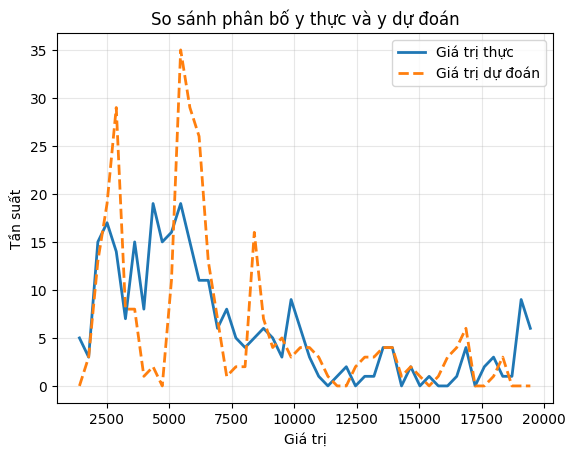

------------------------------------------------------------
SVR Config: Kernel=linear, C=10, Eps=0.1, Test=0.3
Results: RMSE=1543.50, R2=0.882


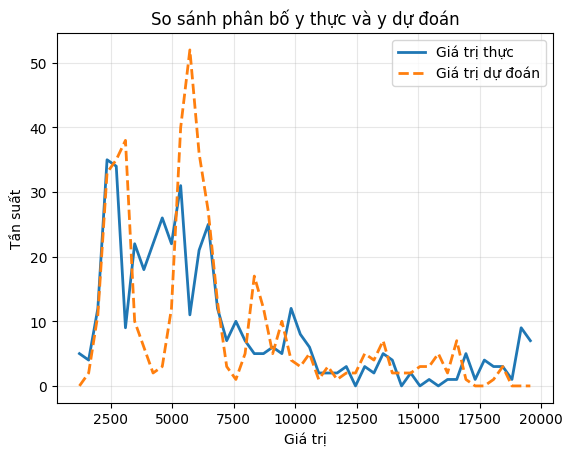

------------------------------------------------------------
SVR Config: Kernel=linear, C=10, Eps=1, Test=0.2
Results: RMSE=1554.99, R2=0.889


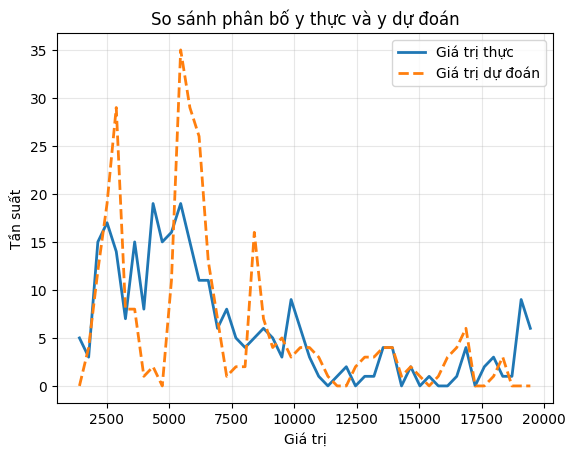

------------------------------------------------------------
SVR Config: Kernel=linear, C=10, Eps=1, Test=0.3
Results: RMSE=1543.25, R2=0.882


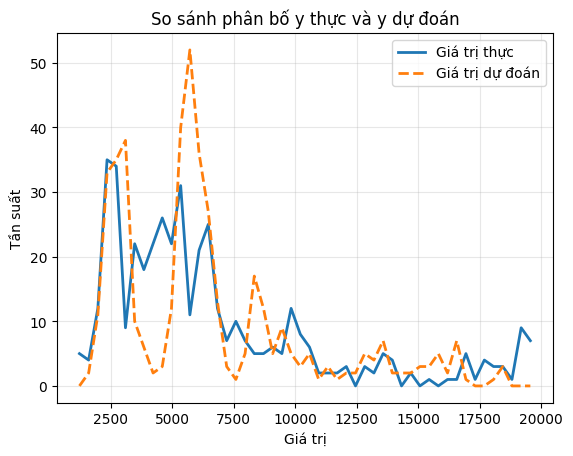

------------------------------------------------------------
SVR Config: Kernel=linear, C=10, Eps=10, Test=0.2
Results: RMSE=1554.78, R2=0.889


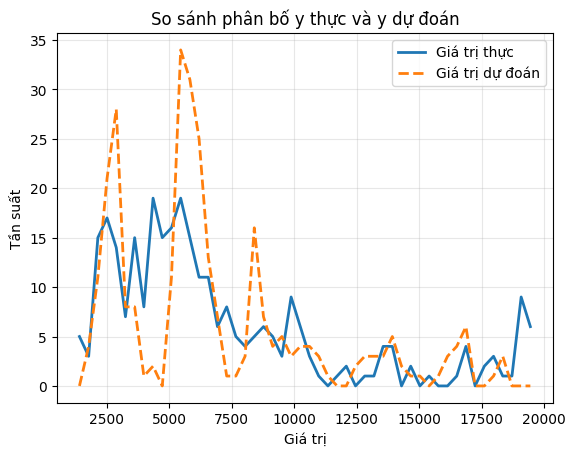

------------------------------------------------------------
SVR Config: Kernel=linear, C=10, Eps=10, Test=0.3
Results: RMSE=1540.74, R2=0.883


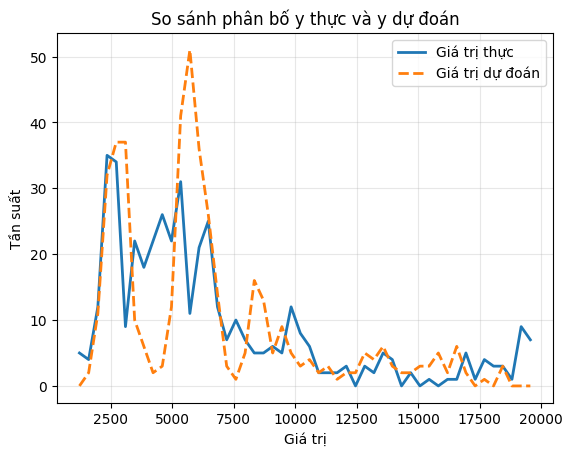

------------------------------------------------------------
SVR Config: Kernel=linear, C=100, Eps=0.1, Test=0.2
Results: RMSE=1227.70, R2=0.931


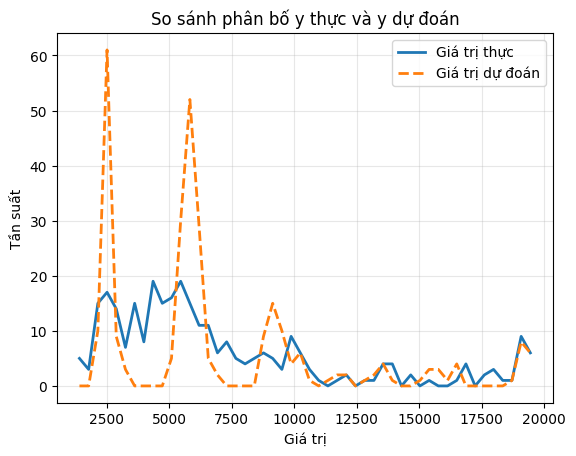

------------------------------------------------------------
SVR Config: Kernel=linear, C=100, Eps=0.1, Test=0.3
Results: RMSE=1202.95, R2=0.928


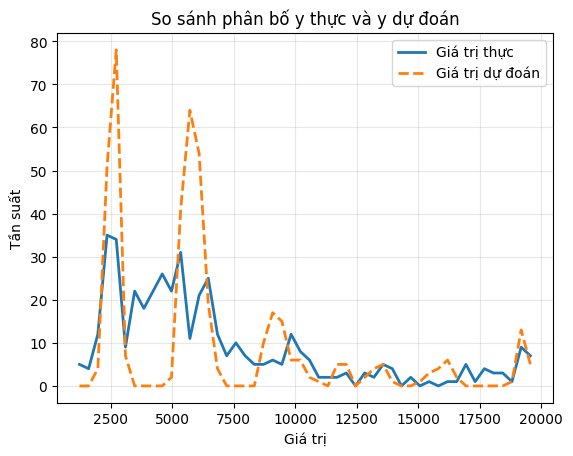

------------------------------------------------------------
SVR Config: Kernel=linear, C=100, Eps=1, Test=0.2
Results: RMSE=1227.99, R2=0.931


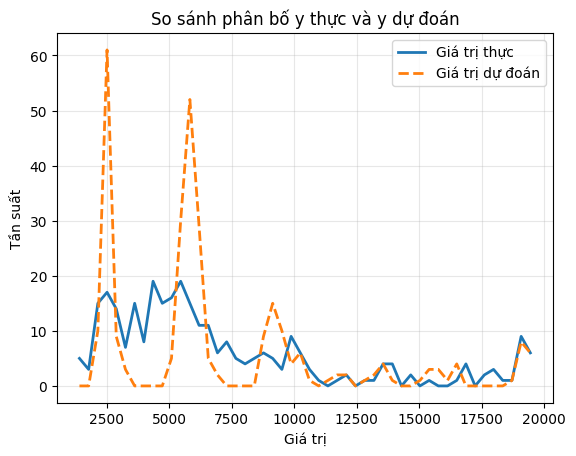

------------------------------------------------------------
SVR Config: Kernel=linear, C=100, Eps=1, Test=0.3
Results: RMSE=1202.82, R2=0.928


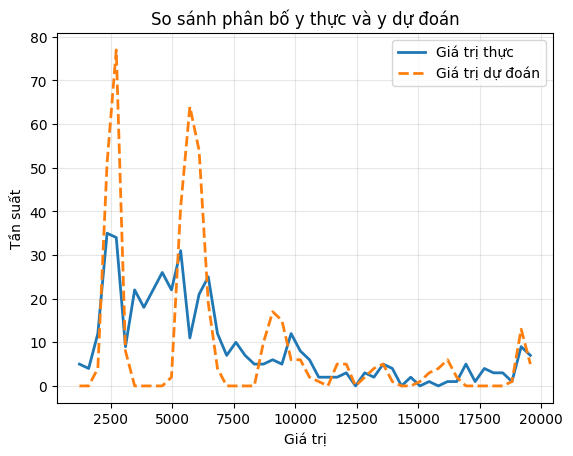

------------------------------------------------------------
SVR Config: Kernel=linear, C=100, Eps=10, Test=0.2
Results: RMSE=1228.00, R2=0.931


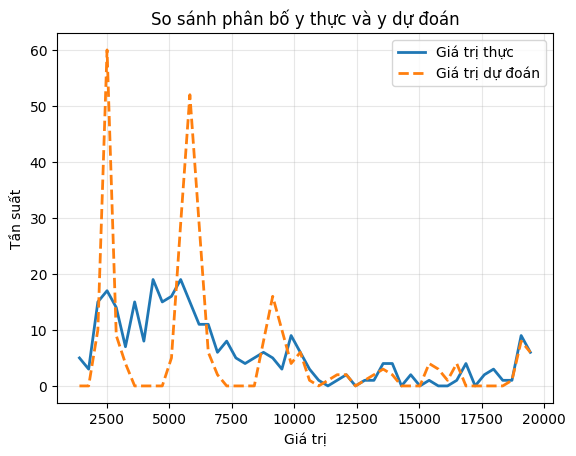

------------------------------------------------------------
SVR Config: Kernel=linear, C=100, Eps=10, Test=0.3
Results: RMSE=1201.35, R2=0.929


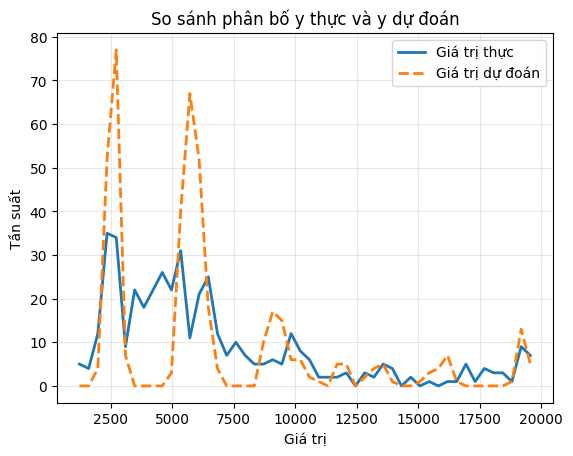

------------------------------------------------------------
SVR Config: Kernel=linear, C=1000, Eps=0.1, Test=0.2
Results: RMSE=1183.59, R2=0.936


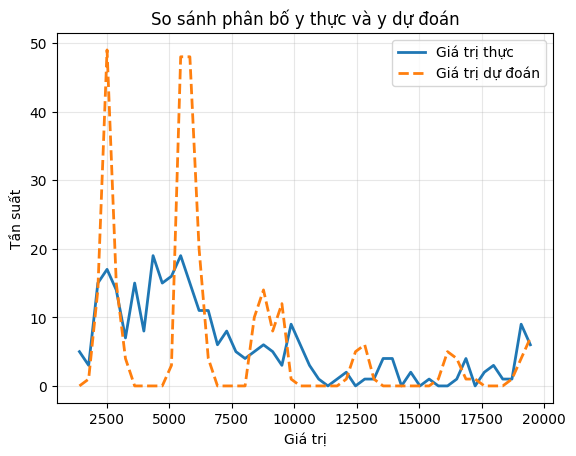

------------------------------------------------------------
SVR Config: Kernel=linear, C=1000, Eps=0.1, Test=0.3
Results: RMSE=1153.22, R2=0.934


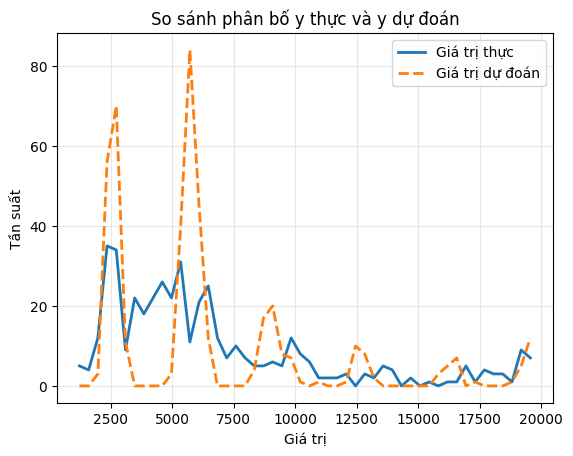

------------------------------------------------------------
SVR Config: Kernel=linear, C=1000, Eps=1, Test=0.2
Results: RMSE=1183.15, R2=0.936


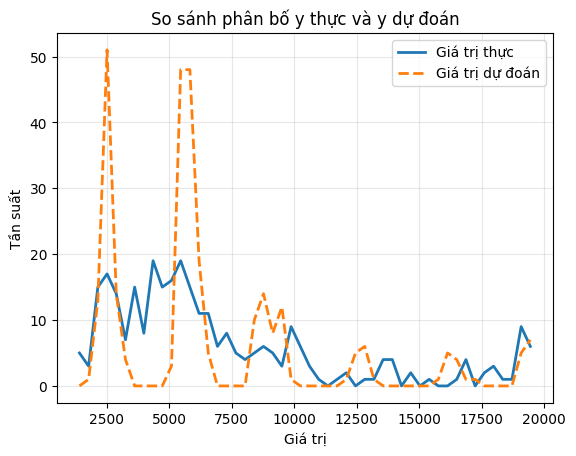

------------------------------------------------------------
SVR Config: Kernel=linear, C=1000, Eps=1, Test=0.3
Results: RMSE=1153.42, R2=0.934


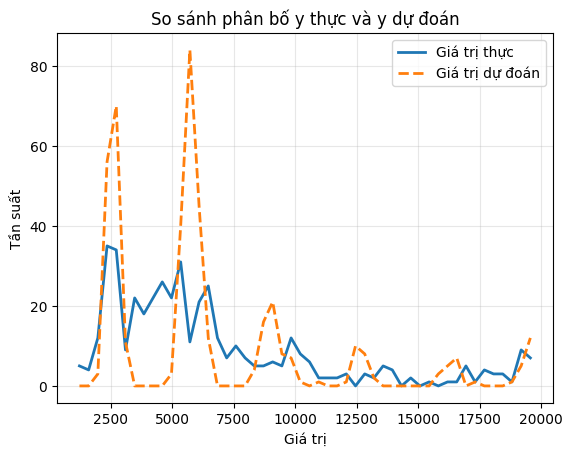

------------------------------------------------------------
SVR Config: Kernel=linear, C=1000, Eps=10, Test=0.2
Results: RMSE=1181.51, R2=0.936


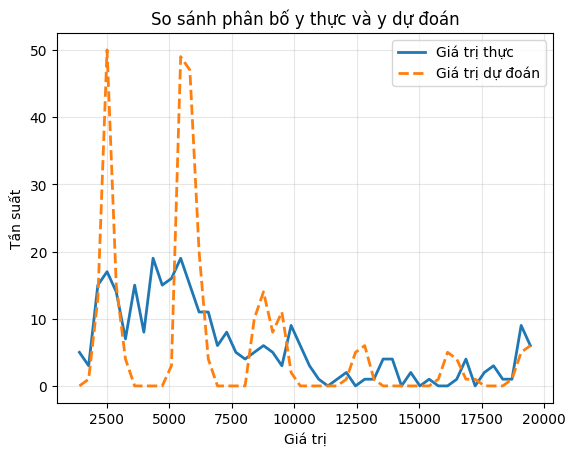

------------------------------------------------------------
SVR Config: Kernel=linear, C=1000, Eps=10, Test=0.3
Results: RMSE=1154.85, R2=0.934


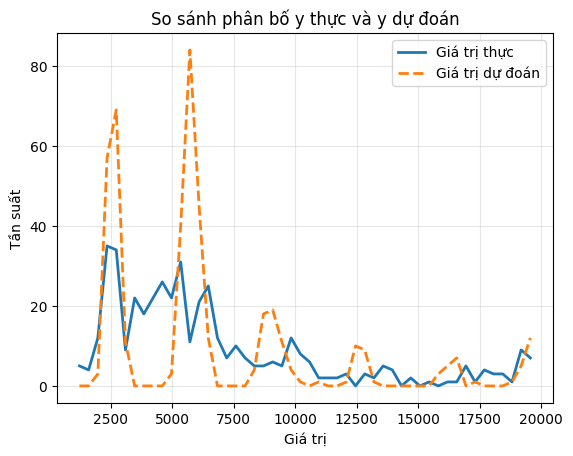

------------------------------------------------------------
SVR Config: Kernel=poly, C=10, Eps=0.1, Test=0.2
Results: RMSE=4820.16, R2=-0.063


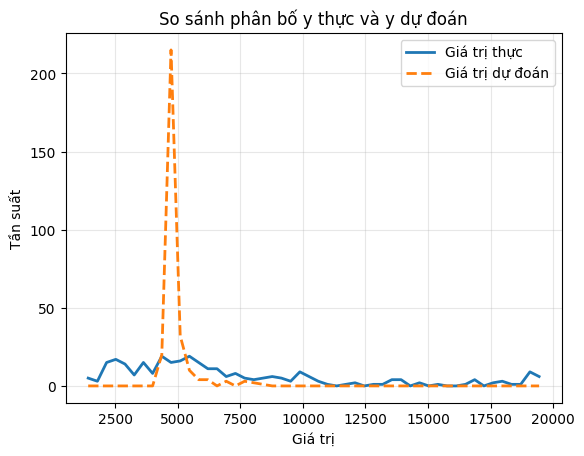

------------------------------------------------------------
SVR Config: Kernel=poly, C=10, Eps=0.1, Test=0.3
Results: RMSE=4588.89, R2=-0.041


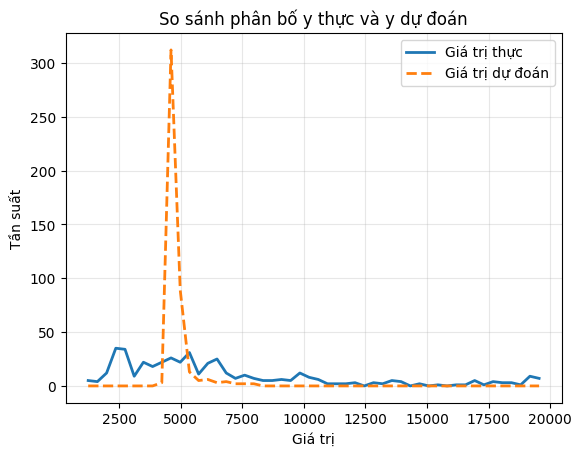

------------------------------------------------------------
SVR Config: Kernel=poly, C=10, Eps=1, Test=0.2
Results: RMSE=4820.01, R2=-0.063


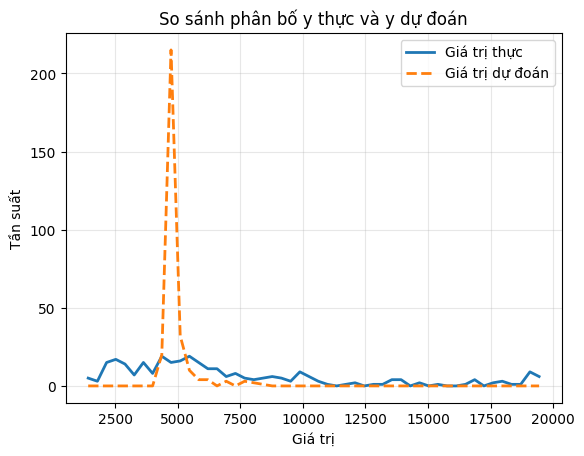

------------------------------------------------------------
SVR Config: Kernel=poly, C=10, Eps=1, Test=0.3
Results: RMSE=4589.24, R2=-0.041


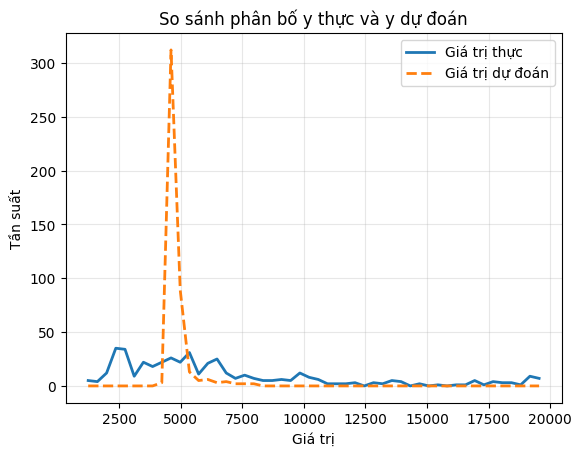

------------------------------------------------------------
SVR Config: Kernel=poly, C=10, Eps=10, Test=0.2
Results: RMSE=4822.09, R2=-0.064


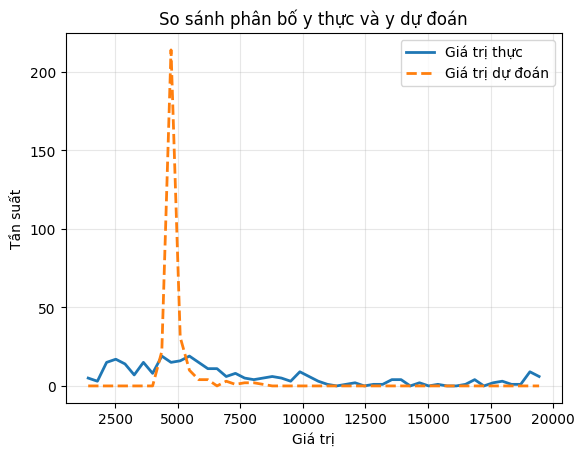

------------------------------------------------------------
SVR Config: Kernel=poly, C=10, Eps=10, Test=0.3
Results: RMSE=4591.58, R2=-0.042


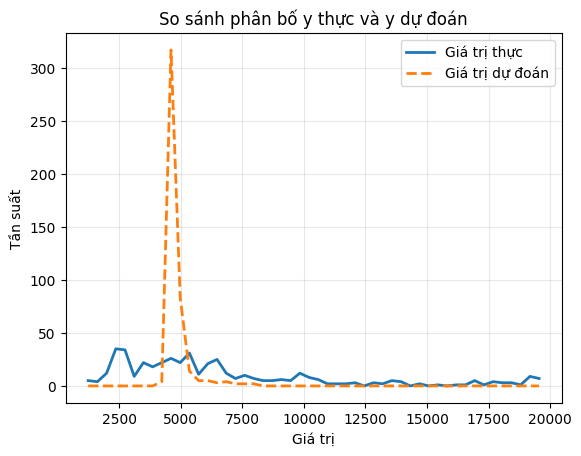

------------------------------------------------------------
SVR Config: Kernel=poly, C=100, Eps=0.1, Test=0.2
Results: RMSE=3644.16, R2=0.392


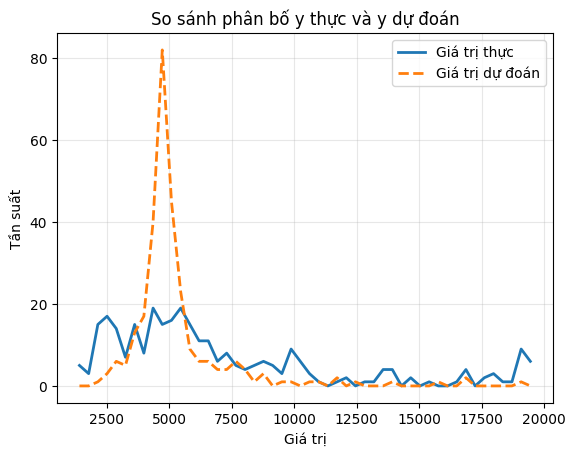

------------------------------------------------------------
SVR Config: Kernel=poly, C=100, Eps=0.1, Test=0.3
Results: RMSE=3553.27, R2=0.376


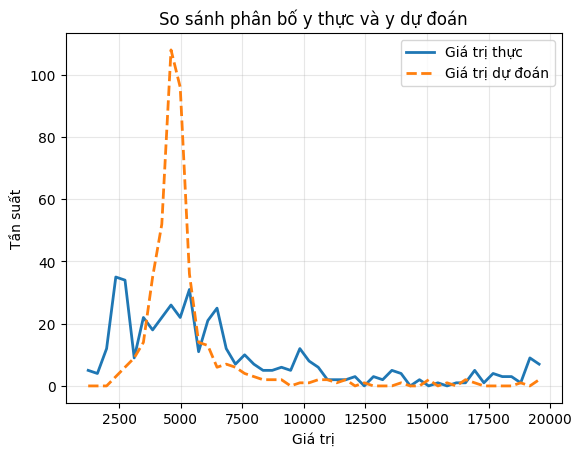

------------------------------------------------------------
SVR Config: Kernel=poly, C=100, Eps=1, Test=0.2
Results: RMSE=3644.07, R2=0.392


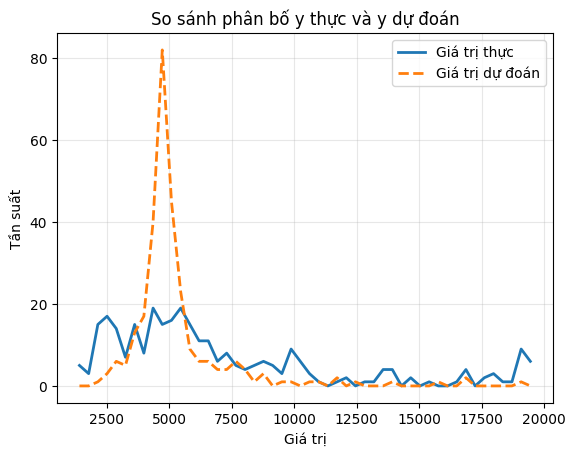

------------------------------------------------------------
SVR Config: Kernel=poly, C=100, Eps=1, Test=0.3
Results: RMSE=3553.20, R2=0.376


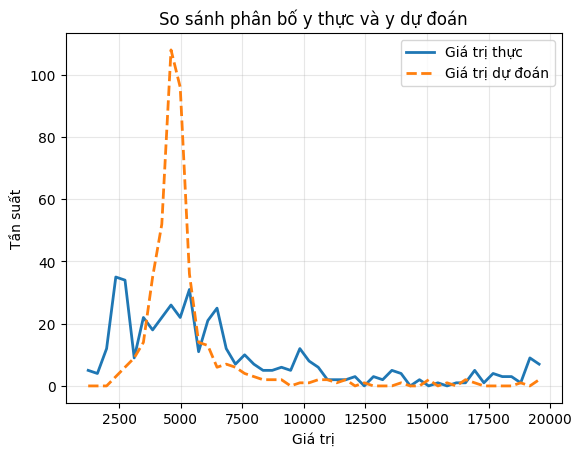

------------------------------------------------------------
SVR Config: Kernel=poly, C=100, Eps=10, Test=0.2
Results: RMSE=3643.09, R2=0.393


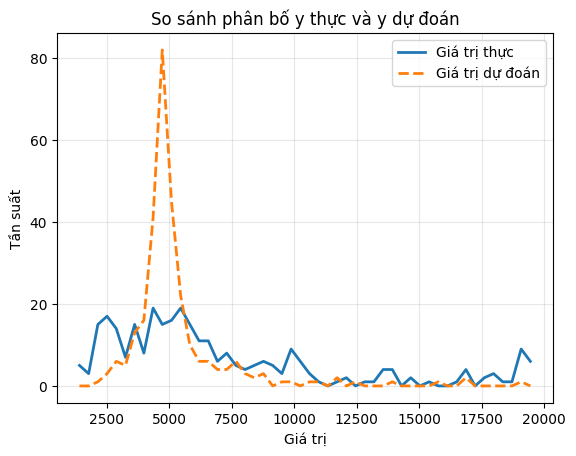

------------------------------------------------------------
SVR Config: Kernel=poly, C=100, Eps=10, Test=0.3
Results: RMSE=3552.47, R2=0.376


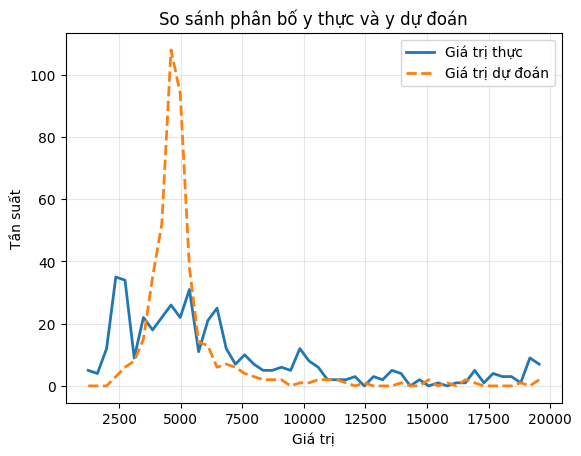

------------------------------------------------------------
SVR Config: Kernel=poly, C=1000, Eps=0.1, Test=0.2
Results: RMSE=2224.05, R2=0.774


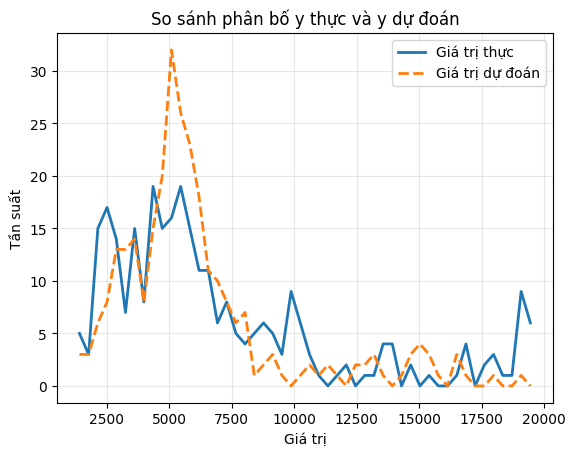

------------------------------------------------------------
SVR Config: Kernel=poly, C=1000, Eps=0.1, Test=0.3
Results: RMSE=2238.80, R2=0.752


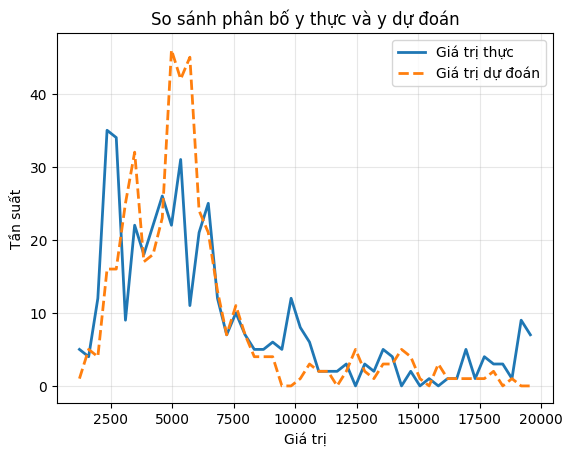

------------------------------------------------------------
SVR Config: Kernel=poly, C=1000, Eps=1, Test=0.2
Results: RMSE=2224.09, R2=0.774


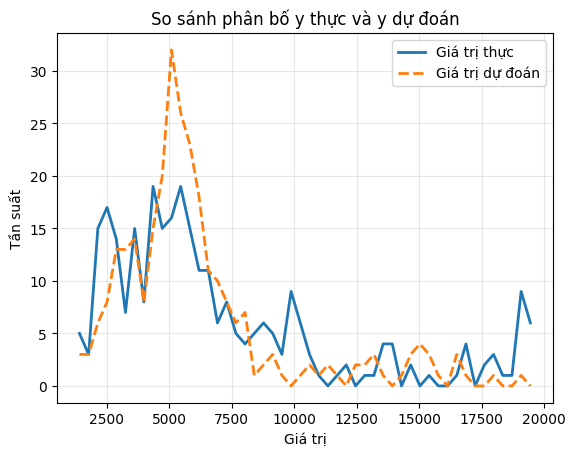

------------------------------------------------------------
SVR Config: Kernel=poly, C=1000, Eps=1, Test=0.3
Results: RMSE=2238.84, R2=0.752


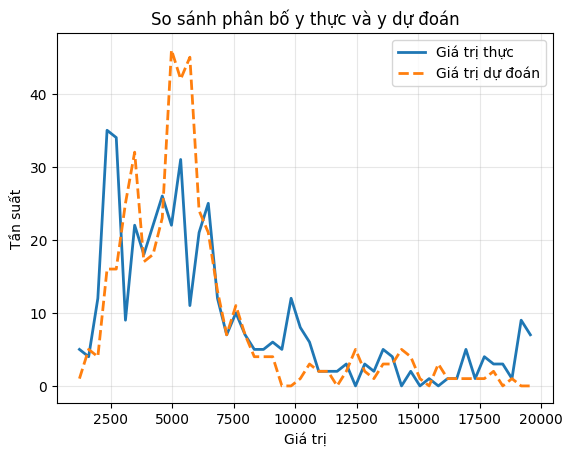

------------------------------------------------------------
SVR Config: Kernel=poly, C=1000, Eps=10, Test=0.2
Results: RMSE=2224.54, R2=0.774


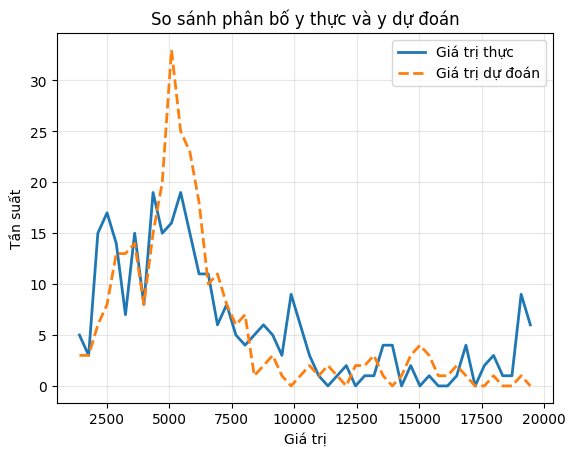

------------------------------------------------------------
SVR Config: Kernel=poly, C=1000, Eps=10, Test=0.3
Results: RMSE=2239.13, R2=0.752


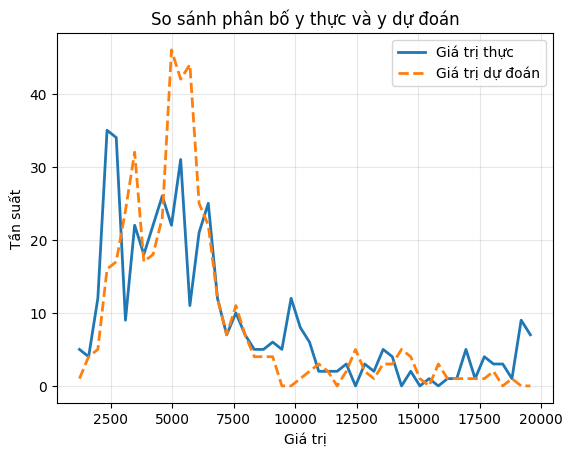

------------------------------------------------------------
SVR Config: Kernel=rbf, C=10, Eps=0.1, Test=0.2
Results: RMSE=4997.89, R2=-0.143


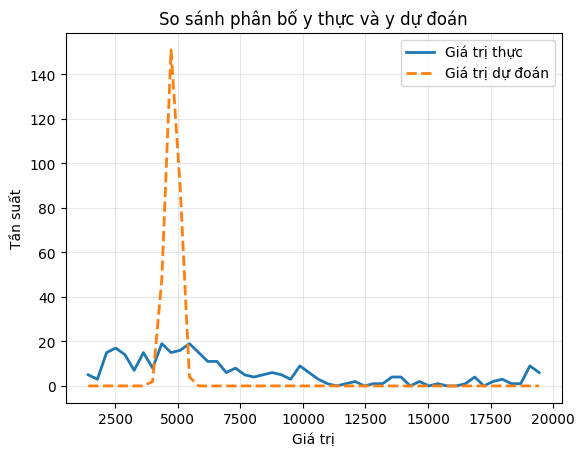

------------------------------------------------------------
SVR Config: Kernel=rbf, C=10, Eps=0.1, Test=0.3
Results: RMSE=4717.19, R2=-0.100


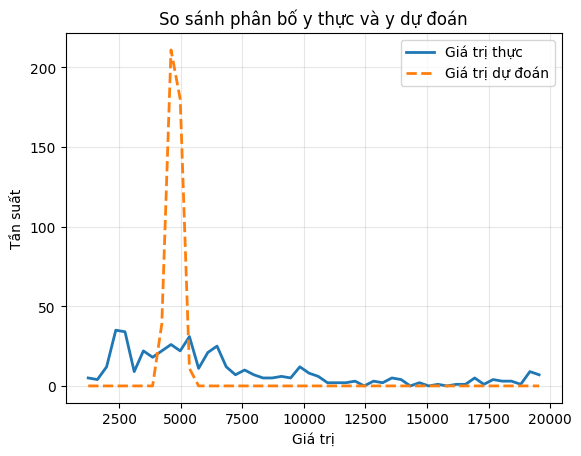

------------------------------------------------------------
SVR Config: Kernel=rbf, C=10, Eps=1, Test=0.2
Results: RMSE=4997.88, R2=-0.143


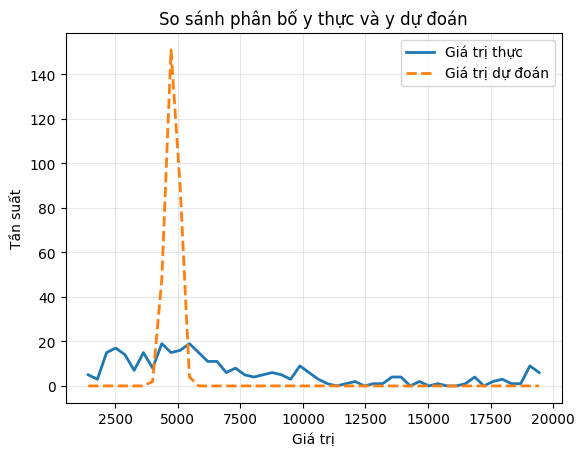

------------------------------------------------------------
SVR Config: Kernel=rbf, C=10, Eps=1, Test=0.3
Results: RMSE=4717.55, R2=-0.100


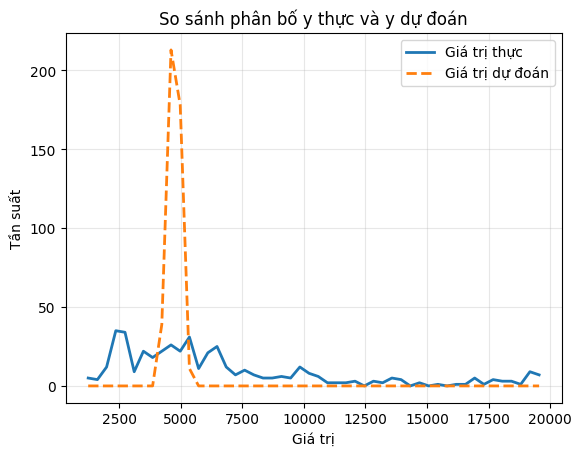

------------------------------------------------------------
SVR Config: Kernel=rbf, C=10, Eps=10, Test=0.2
Results: RMSE=4996.74, R2=-0.142


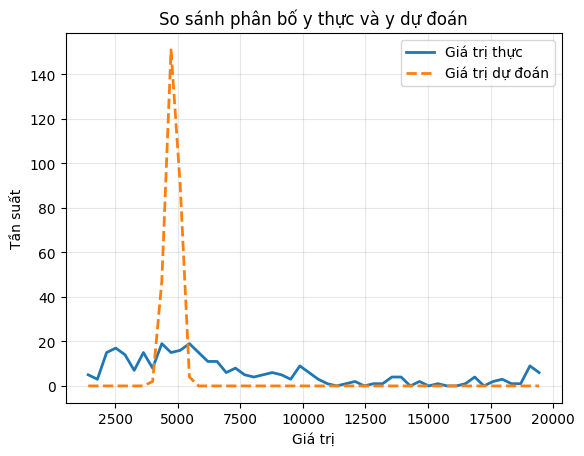

------------------------------------------------------------
SVR Config: Kernel=rbf, C=10, Eps=10, Test=0.3
Results: RMSE=4716.78, R2=-0.100


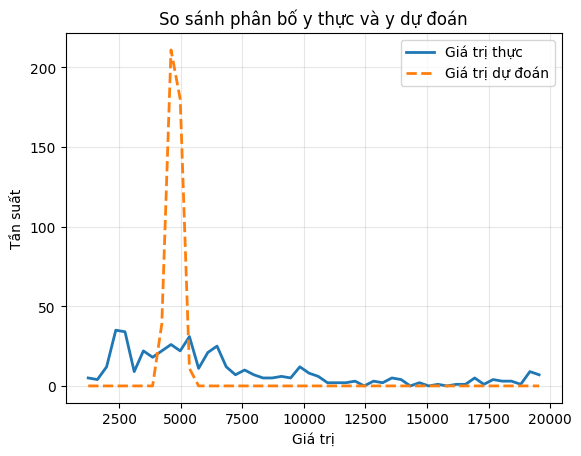

------------------------------------------------------------
SVR Config: Kernel=rbf, C=100, Eps=0.1, Test=0.2
Results: RMSE=3902.39, R2=0.303


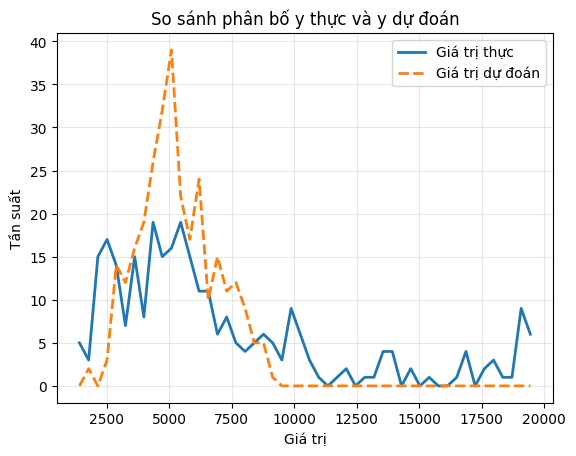

------------------------------------------------------------
SVR Config: Kernel=rbf, C=100, Eps=0.1, Test=0.3
Results: RMSE=3712.30, R2=0.319


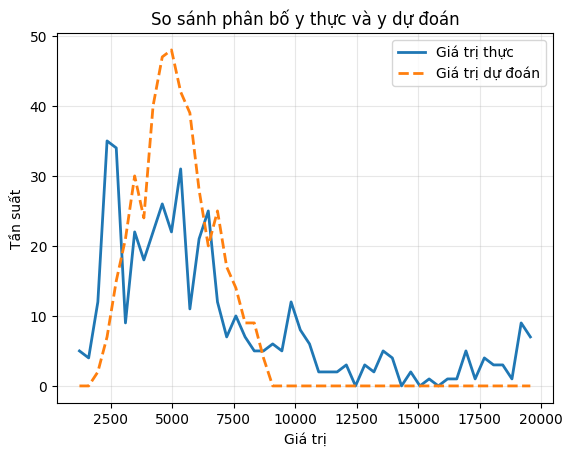

------------------------------------------------------------
SVR Config: Kernel=rbf, C=100, Eps=1, Test=0.2
Results: RMSE=3902.50, R2=0.303


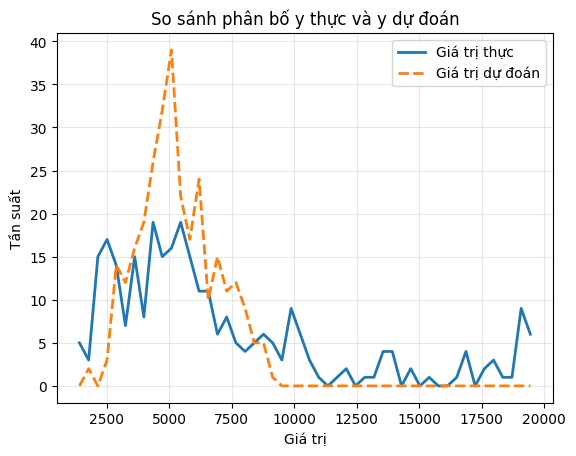

------------------------------------------------------------
SVR Config: Kernel=rbf, C=100, Eps=1, Test=0.3
Results: RMSE=3712.35, R2=0.319


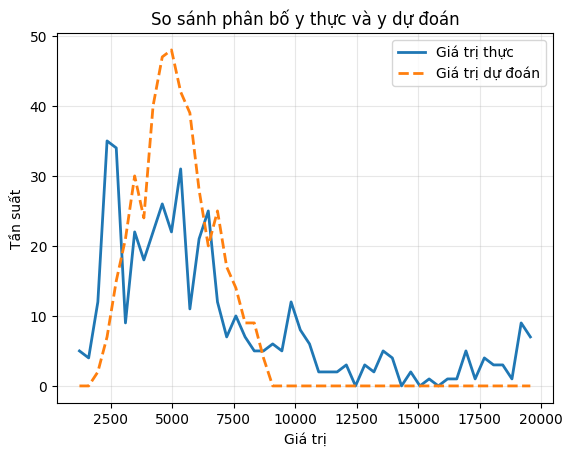

------------------------------------------------------------
SVR Config: Kernel=rbf, C=100, Eps=10, Test=0.2
Results: RMSE=3903.55, R2=0.303


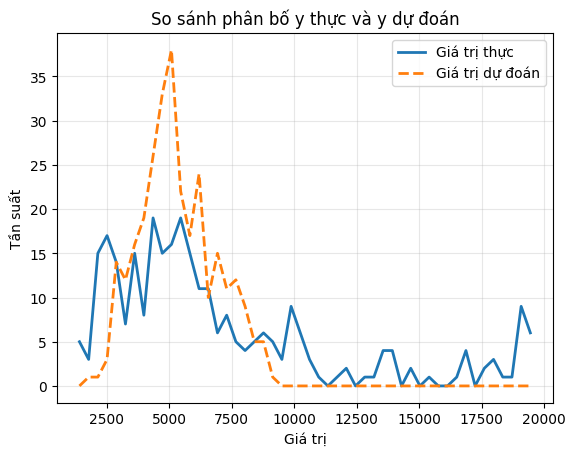

------------------------------------------------------------
SVR Config: Kernel=rbf, C=100, Eps=10, Test=0.3
Results: RMSE=3712.33, R2=0.319


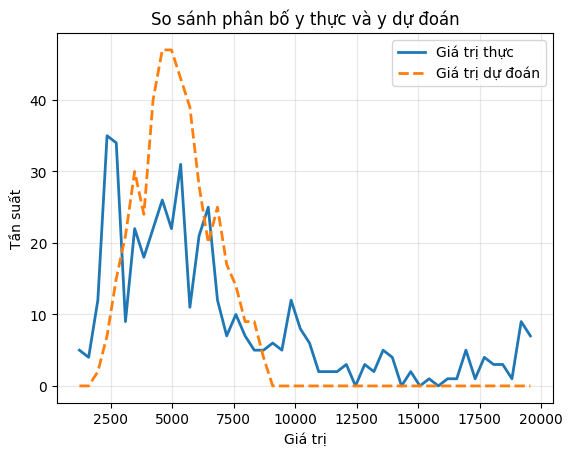

------------------------------------------------------------
SVR Config: Kernel=rbf, C=1000, Eps=0.1, Test=0.2
Results: RMSE=1834.59, R2=0.846


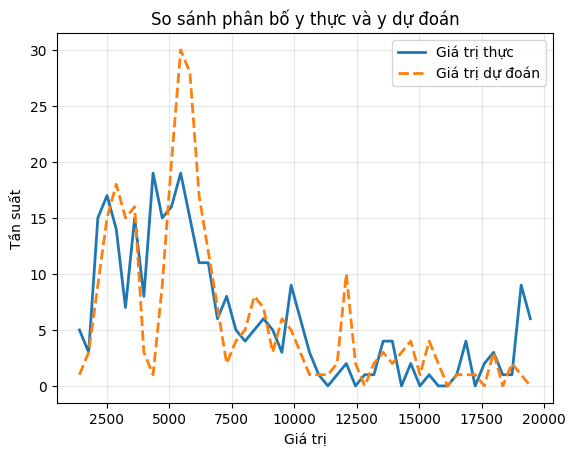

------------------------------------------------------------
SVR Config: Kernel=rbf, C=1000, Eps=0.1, Test=0.3
Results: RMSE=1729.57, R2=0.852


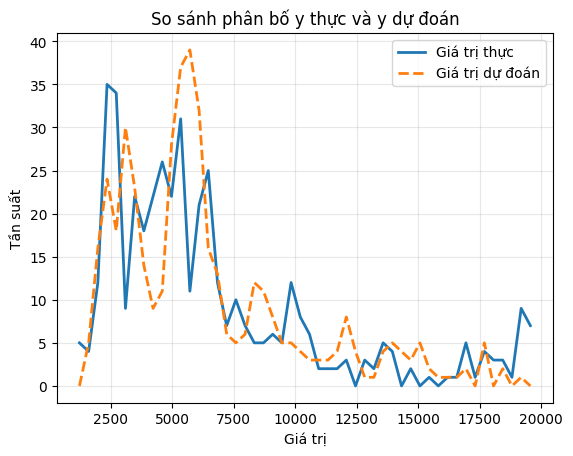

------------------------------------------------------------
SVR Config: Kernel=rbf, C=1000, Eps=1, Test=0.2
Results: RMSE=1834.58, R2=0.846


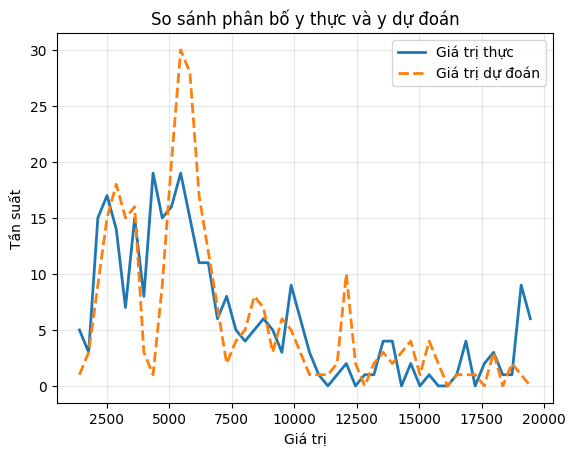

------------------------------------------------------------
SVR Config: Kernel=rbf, C=1000, Eps=1, Test=0.3
Results: RMSE=1729.57, R2=0.852


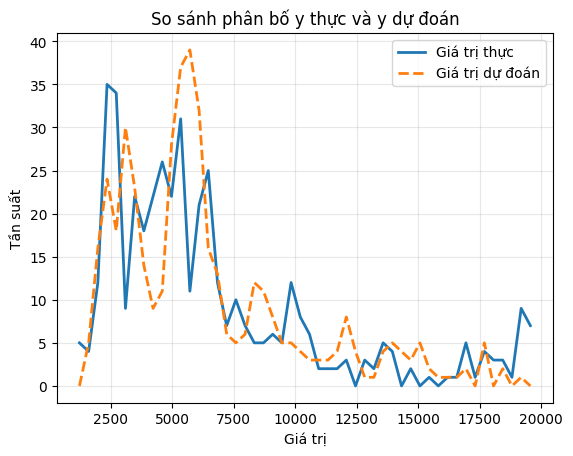

------------------------------------------------------------
SVR Config: Kernel=rbf, C=1000, Eps=10, Test=0.2
Results: RMSE=1834.61, R2=0.846


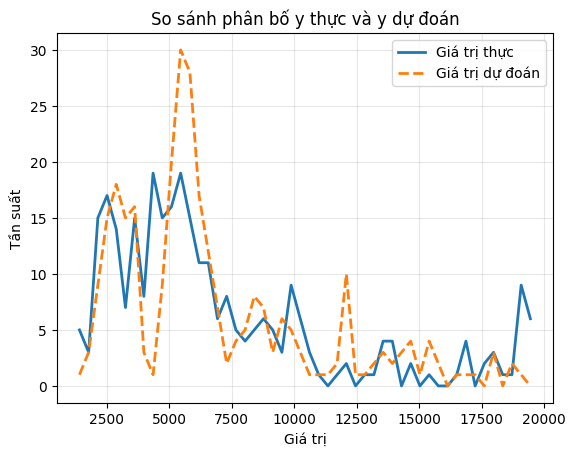

------------------------------------------------------------
SVR Config: Kernel=rbf, C=1000, Eps=10, Test=0.3
Results: RMSE=1729.74, R2=0.852


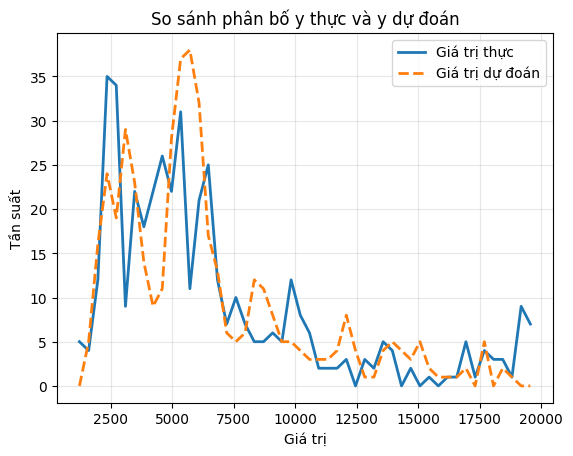

In [9]:
results_list = validate_svr(X=X_encode, y=y_origin)

In [10]:
df_2 = pd.DataFrame(results_list) 

In [11]:
df_2

Kernel     C  Epsilon  Test_Size          MAE         RMSE        R2
0   linear    10      0.1        0.2  1137.964659  1554.966756  0.889367
1   linear    10      0.1        0.3  1128.847194  1543.496386  0.882208
2   linear    10      1.0        0.2  1138.041491  1554.987619  0.889364
3   linear    10      1.0        0.3  1128.761137  1543.245266  0.882246
4   linear    10     10.0        0.2  1137.987986  1554.783915  0.889393
5   linear    10     10.0        0.3  1127.908857  1540.740684  0.882628
6   linear   100      0.1        0.2   899.459632  1227.698505  0.931036
7   linear   100      0.1        0.3   890.673800  1202.946293  0.928452
8   linear   100      1.0        0.2   899.332825  1227.990190  0.931003
9   linear   100      1.0        0.3   890.563305  1202.823640  0.928467
10  linear   100     10.0        0.2   898.093303  1228.002395  0.931002
11  linear   100     10.0        0.3   888.975499  1201.350923  0.928642
12  linear  1000      0.1        0.2   886.687156  1183.593671  0.935902
13  linear  1000      0.1        0.3   869.607930  1153.220498  0.934245
14  linear  1000      1.0        0.2   886.439408  1183.145329  0.935950
15  linear  1000      1.0        0.3   869.893955  1153.415916  0.934223
16  linear  1000     10.0        0.2   884.661581  1181.509153  0.936127
17  linear  1000     10.0        0.3   870.421564  1154.850583  0.934059
18    poly    10      0.1        0.2  3189.725229  4820.158793 -0.063075
19    poly    10      0.1        0.3  3026.377268  4588.886211 -0.041164
20    poly    10      1.0        0.2  3189.627320  4820.009127 -0.063009
21    poly    10      1.0        0.3  3026.538492  4589.236068 -0.041323
22    poly    10     10.0        0.2  3190.917961  4822.090160 -0.063927
23    poly    10     10.0        0.3  3027.632849  4591.582507 -0.042388
24    poly   100      0.1        0.2  2378.116151  3644.164201  0.392373
25    poly   100      0.1        0.3  2288.139995  3553.270238  0.375747
26    poly   100      1.0        0.2  2378.036711  3644.069199  0.392405
27    poly   100      1.0        0.3  2288.114216  3553.197857  0.375772
28    poly   100     10.0        0.2  2377.221951  3643.092615  0.392730
29    poly   100     10.0        0.3  2287.834103  3552.467608  0.376029
30    poly  1000      0.1        0.2  1525.334485  2224.047250  0.773677
31    poly  1000      0.1        0.3  1498.262757  2238.801874  0.752180
32    poly  1000      1.0        0.2  1525.385750  2224.093056  0.773667
33    poly  1000      1.0        0.3  1498.266654  2238.839163  0.752172
34    poly  1000     10.0        0.2  1526.003296  2224.536284  0.773577
35    poly  1000     10.0        0.3  1498.295304  2239.129947  0.752108
36     rbf    10      0.1        0.2  3242.986481  4997.893461 -0.142918
37     rbf    10      0.1        0.3  3056.323927  4717.188198 -0.100198
38     rbf    10      1.0        0.2  3242.979191  4997.878682 -0.142911
39     rbf    10      1.0        0.3  3056.497396  4717.547175 -0.100366
40     rbf    10     10.0        0.2  3242.278816  4996.738226 -0.142390
41     rbf    10     10.0        0.3  3055.996962  4716.783946 -0.100010
42     rbf   100      0.1        0.2  2462.240210  3902.387237  0.303210
43     rbf   100      0.1        0.3  2316.549308  3712.301309  0.318618
44     rbf   100      1.0        0.2  2462.283543  3902.497491  0.303171
45     rbf   100      1.0        0.3  2316.562933  3712.347372  0.318601
46     rbf   100     10.0        0.2  2462.749567  3903.545257  0.302797
47     rbf   100     10.0        0.3  2316.487285  3712.326206  0.318608
48     rbf  1000      0.1        0.2  1303.998759  1834.588153  0.846001
49     rbf  1000      0.1        0.3  1257.023640  1729.566859  0.852096
50     rbf  1000      1.0        0.2  1304.003878  1834.584831  0.846001
51     rbf  1000      1.0        0.3  1257.039052  1729.574870  0.852095
52     rbf  1000     10.0        0.2  1304.126981  1834.606257  0.845998
53     rbf  1000     10.0        0.3  1257.267745  1729.738078

Nhận xét:
- Mô hình tốt nhất: 
    - Kernel Linear mang lại kết quả tốt nhất trong các thử nghiệm. Với cấu hình C=1000, mô hình đạt chỉ số R^2 = 0.93 và sai số RMSE thấp nhất (khoảng 1153).
- Tác động của tham số điều hòa C:
    - Kết quả cho thấy khi giá trị C tăng từ 10 lên 1000, độ chính xác của mô hình cải thiện rõ rệt trên tất cả các loại Kernel.
    - Với C=1000, mô hình SVR tập trung nhiều hơn vào việc giảm thiểu sai số dự báo, giúp các chỉ số R^2 tăng vọt từ mức âm (ở Kernel RBF/Poly với C thấp) lên mức trên 0.7x và 0.8x. Điều này cho thấy mô hình cần một trọng số đủ lớn để khớp với dải giá trị rộng của biến thu nhập.
- So sánh giữa các loại Kernel:
    - Kernel RBF: Cần các giá trị C lớn mới bắt đầu phát huy hiệu quả R^2 = 0.85 tại C=1000. Dù có khả năng học phi tuyến tốt, nhưng trong bài toán này vẫn chưa tối ưu bằng Linear.
    - Kernel Poly: Cho kết quả ở mức trung bình R^2 = 0.77 tại C=1000, cho thấy việc sử dụng các hàm đa thức bậc cao không mang lại nhiều lợi thế cho dữ liệu lương hiện tại.

### Thực hiện với dữ liệu đã giảm chiều (PCA giảm về 1/3  số chiều)

------------------------------------------------------------
SVR Config: Kernel=linear, C=10, Eps=0.1, Test=0.2
Results: RMSE=2948.27, R2=0.602


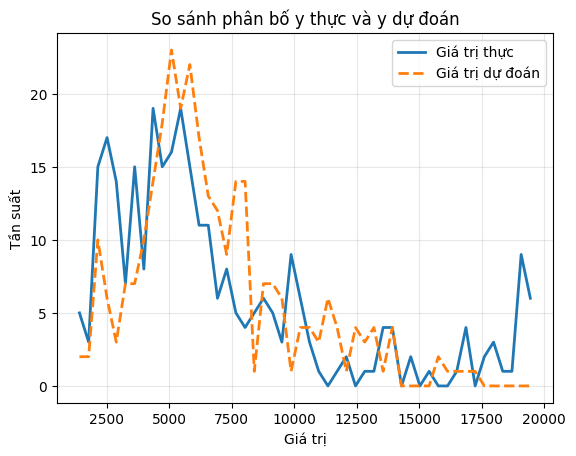

------------------------------------------------------------
SVR Config: Kernel=linear, C=10, Eps=0.1, Test=0.3
Results: RMSE=2804.63, R2=0.611


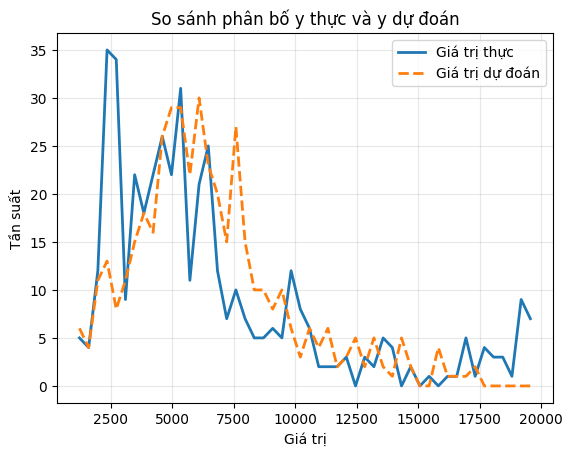

------------------------------------------------------------
SVR Config: Kernel=linear, C=10, Eps=1, Test=0.2
Results: RMSE=2948.42, R2=0.602


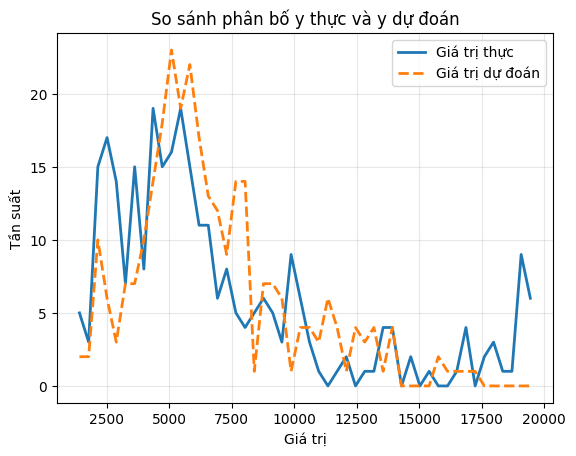

------------------------------------------------------------
SVR Config: Kernel=linear, C=10, Eps=1, Test=0.3
Results: RMSE=2804.78, R2=0.611


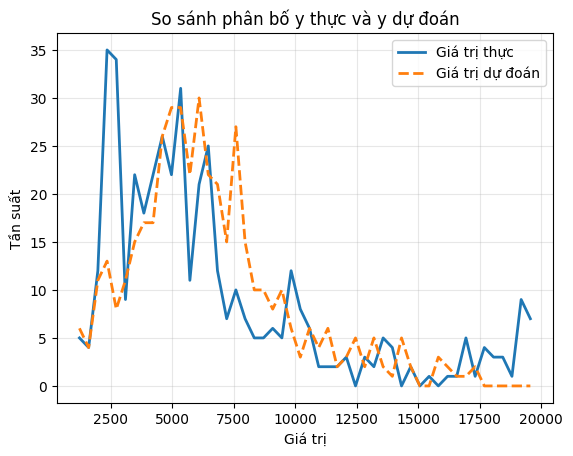

------------------------------------------------------------
SVR Config: Kernel=linear, C=10, Eps=10, Test=0.2
Results: RMSE=2948.60, R2=0.602


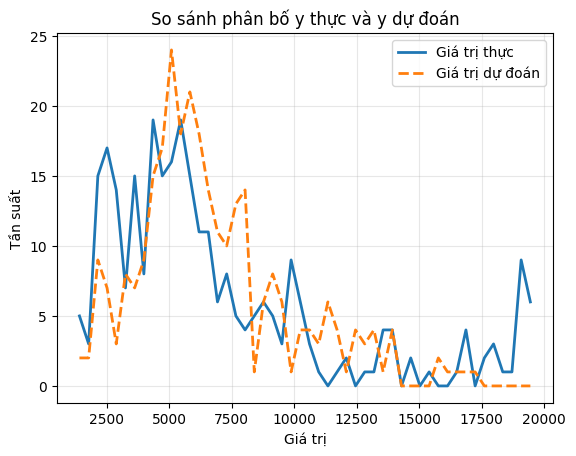

------------------------------------------------------------
SVR Config: Kernel=linear, C=10, Eps=10, Test=0.3
Results: RMSE=2804.89, R2=0.611


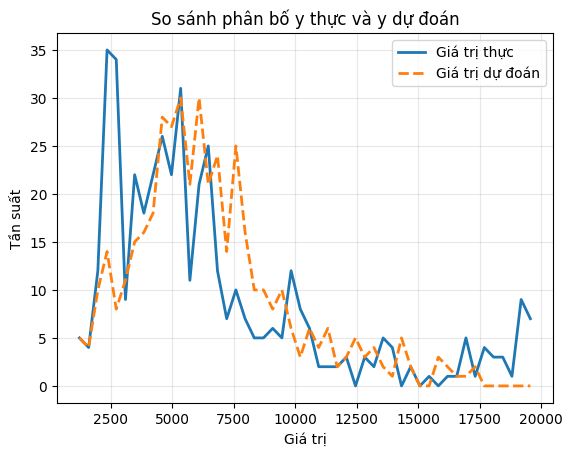

------------------------------------------------------------
SVR Config: Kernel=linear, C=100, Eps=0.1, Test=0.2
Results: RMSE=2893.42, R2=0.617


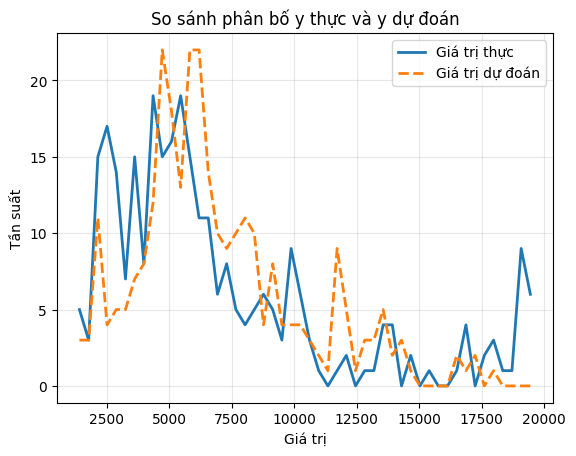

------------------------------------------------------------
SVR Config: Kernel=linear, C=100, Eps=0.1, Test=0.3
Results: RMSE=2741.72, R2=0.628


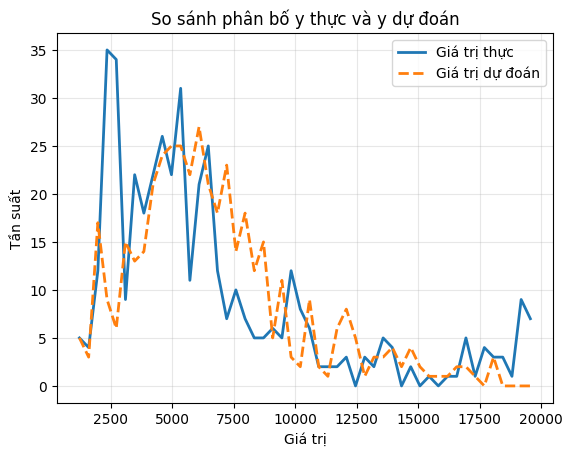

------------------------------------------------------------
SVR Config: Kernel=linear, C=100, Eps=1, Test=0.2
Results: RMSE=2893.36, R2=0.617


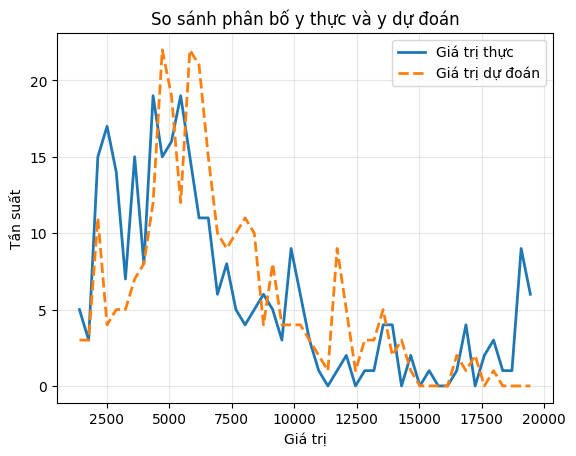

------------------------------------------------------------
SVR Config: Kernel=linear, C=100, Eps=1, Test=0.3
Results: RMSE=2741.84, R2=0.628


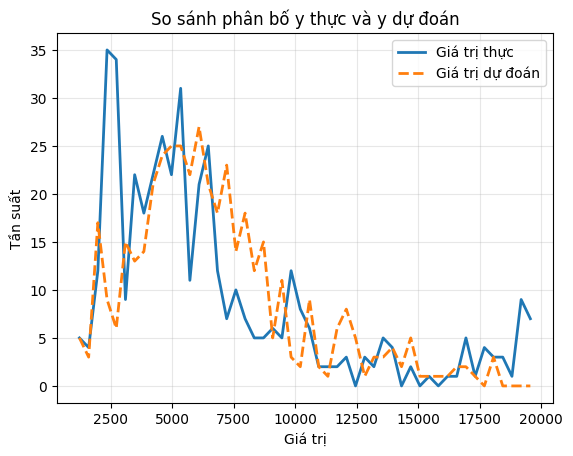

------------------------------------------------------------
SVR Config: Kernel=linear, C=100, Eps=10, Test=0.2
Results: RMSE=2894.03, R2=0.617


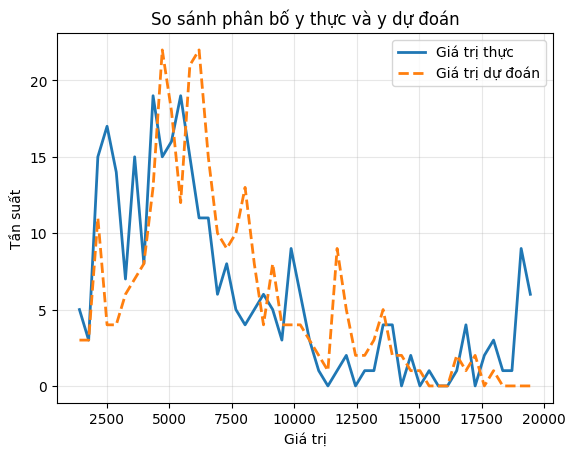

------------------------------------------------------------
SVR Config: Kernel=linear, C=100, Eps=10, Test=0.3
Results: RMSE=2741.86, R2=0.628


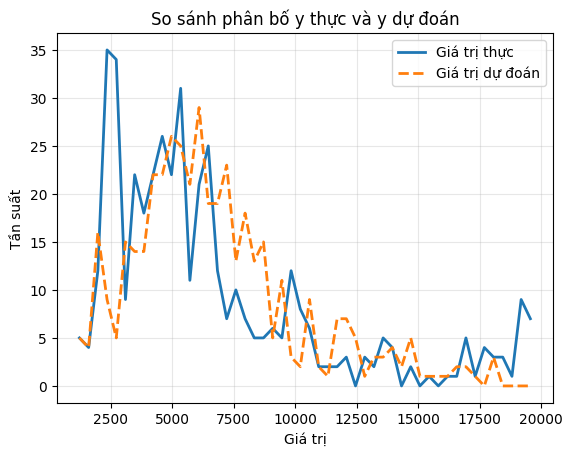

------------------------------------------------------------
SVR Config: Kernel=linear, C=1000, Eps=0.1, Test=0.2
Results: RMSE=2890.31, R2=0.618


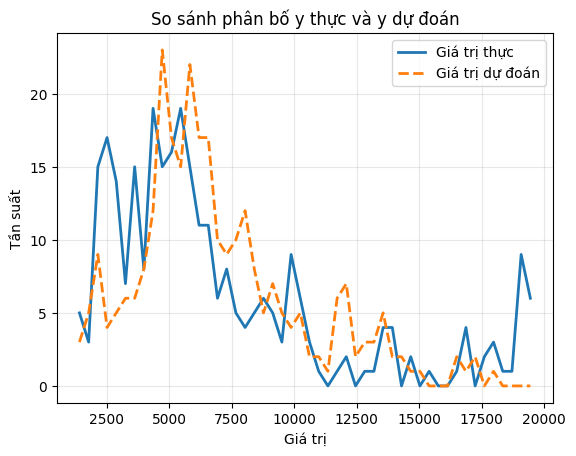

------------------------------------------------------------
SVR Config: Kernel=linear, C=1000, Eps=0.1, Test=0.3
Results: RMSE=2737.56, R2=0.629


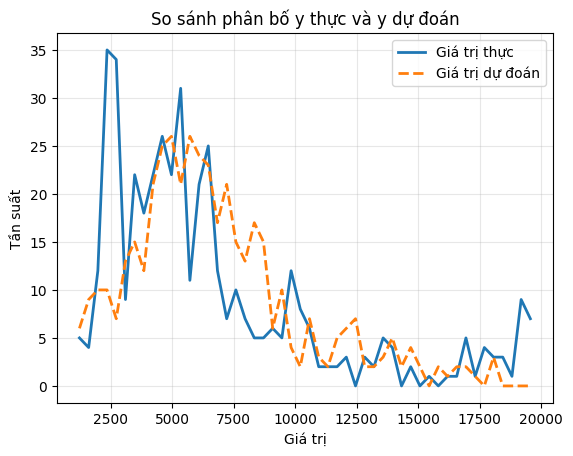

------------------------------------------------------------
SVR Config: Kernel=linear, C=1000, Eps=1, Test=0.2
Results: RMSE=2890.36, R2=0.618


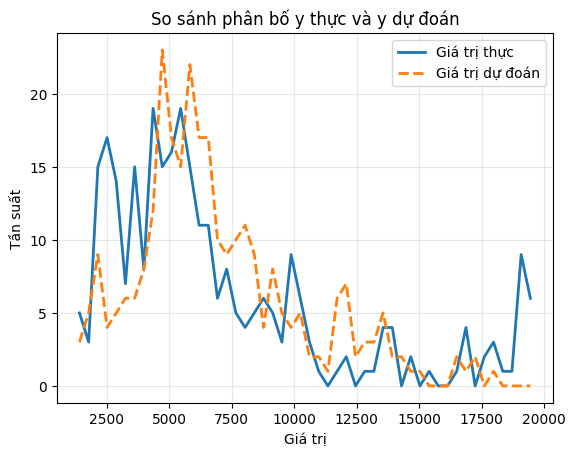

------------------------------------------------------------
SVR Config: Kernel=linear, C=1000, Eps=1, Test=0.3
Results: RMSE=2737.63, R2=0.629


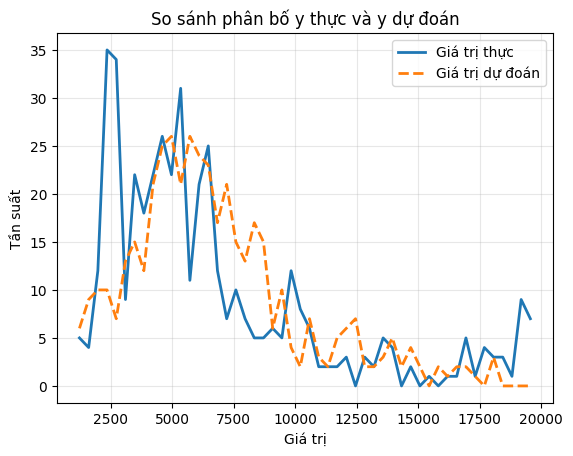

------------------------------------------------------------
SVR Config: Kernel=linear, C=1000, Eps=10, Test=0.2
Results: RMSE=2891.00, R2=0.618


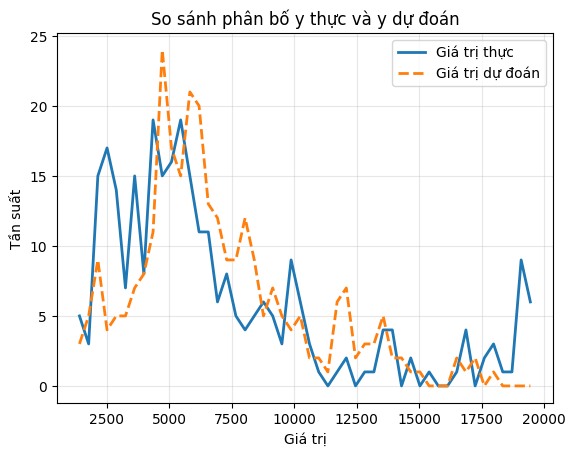

------------------------------------------------------------
SVR Config: Kernel=linear, C=1000, Eps=10, Test=0.3
Results: RMSE=2737.43, R2=0.629


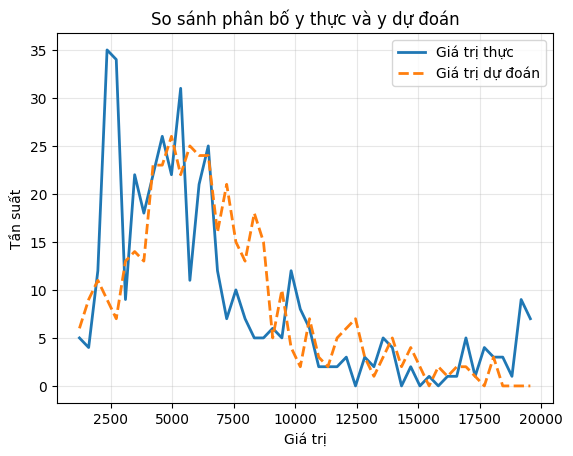

------------------------------------------------------------
SVR Config: Kernel=poly, C=10, Eps=0.1, Test=0.2
Results: RMSE=4494.98, R2=0.076


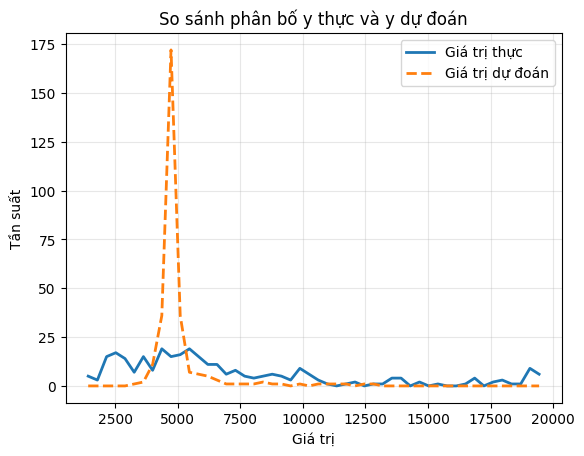

------------------------------------------------------------
SVR Config: Kernel=poly, C=10, Eps=0.1, Test=0.3
Results: RMSE=4318.47, R2=0.078


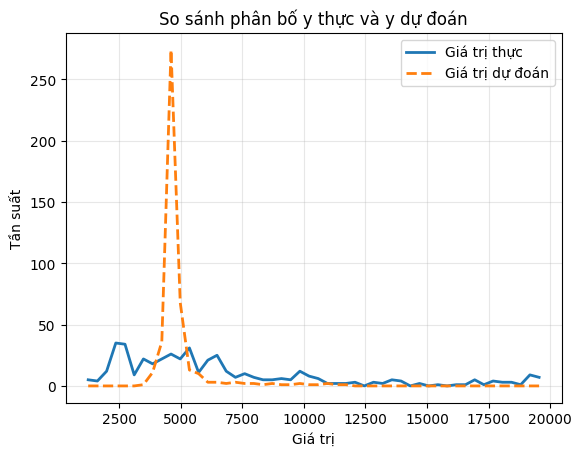

------------------------------------------------------------
SVR Config: Kernel=poly, C=10, Eps=1, Test=0.2
Results: RMSE=4494.98, R2=0.076


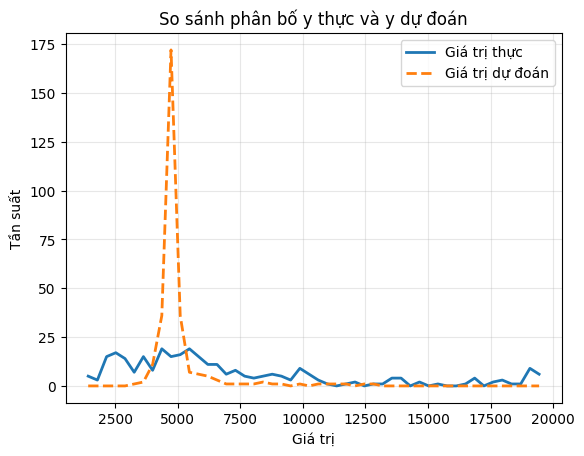

------------------------------------------------------------
SVR Config: Kernel=poly, C=10, Eps=1, Test=0.3
Results: RMSE=4318.11, R2=0.078


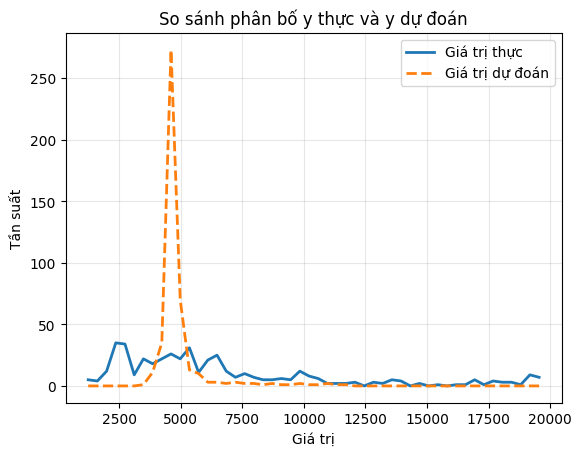

------------------------------------------------------------
SVR Config: Kernel=poly, C=10, Eps=10, Test=0.2
Results: RMSE=4494.78, R2=0.076


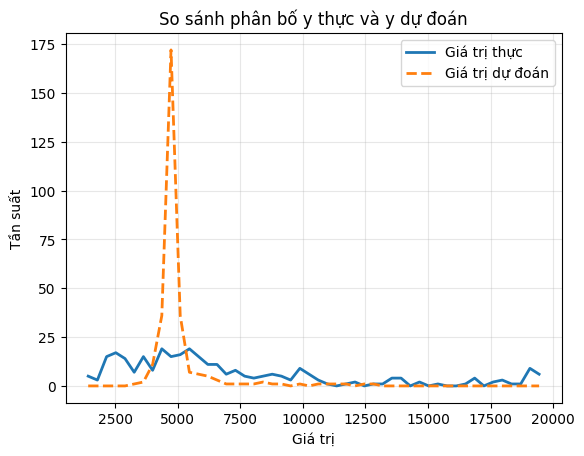

------------------------------------------------------------
SVR Config: Kernel=poly, C=10, Eps=10, Test=0.3
Results: RMSE=4315.57, R2=0.079


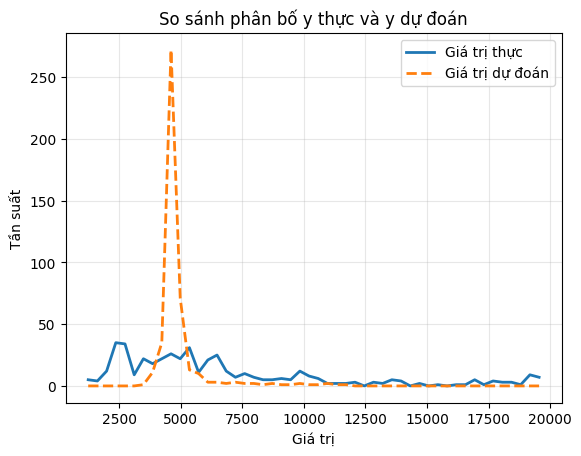

------------------------------------------------------------
SVR Config: Kernel=poly, C=100, Eps=0.1, Test=0.2
Results: RMSE=3743.78, R2=0.359


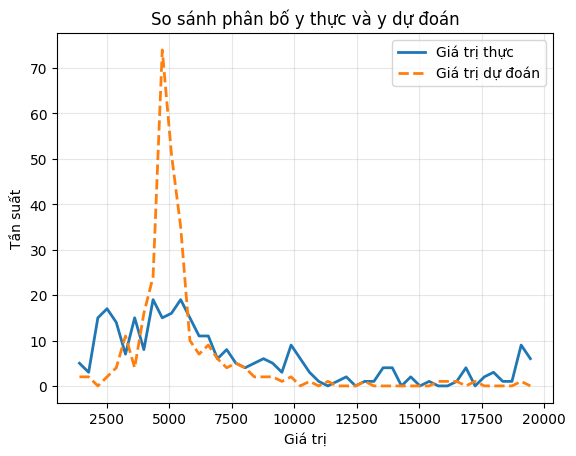

------------------------------------------------------------
SVR Config: Kernel=poly, C=100, Eps=0.1, Test=0.3
Results: RMSE=3603.38, R2=0.358


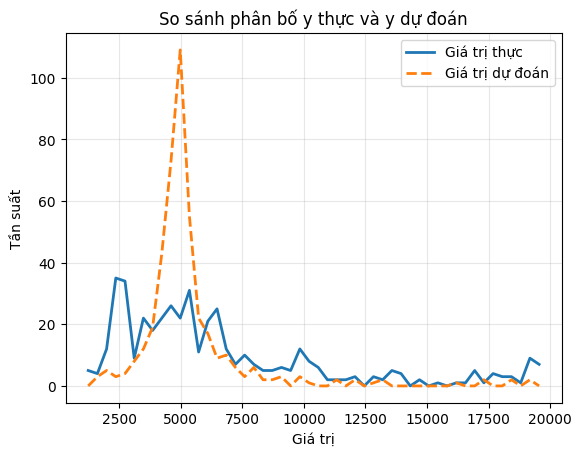

------------------------------------------------------------
SVR Config: Kernel=poly, C=100, Eps=1, Test=0.2
Results: RMSE=3743.75, R2=0.359


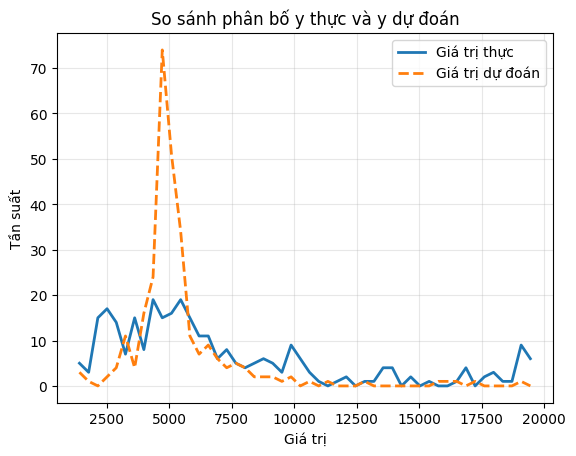

------------------------------------------------------------
SVR Config: Kernel=poly, C=100, Eps=1, Test=0.3
Results: RMSE=3603.34, R2=0.358


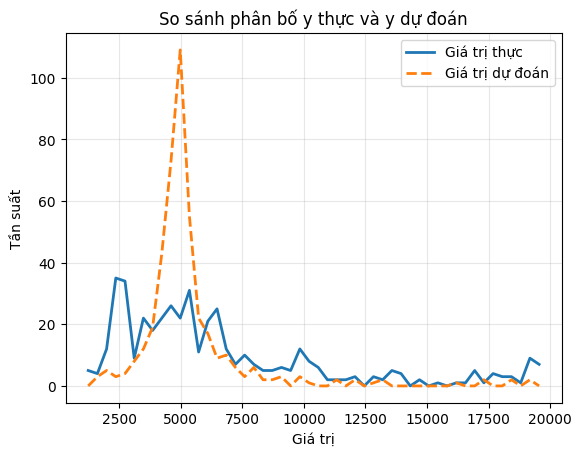

------------------------------------------------------------
SVR Config: Kernel=poly, C=100, Eps=10, Test=0.2
Results: RMSE=3743.22, R2=0.359


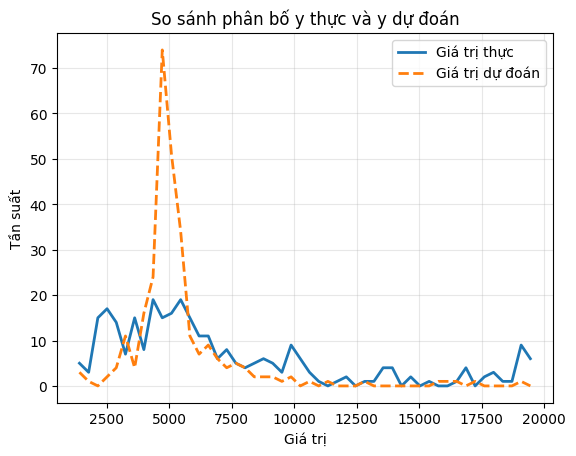

------------------------------------------------------------
SVR Config: Kernel=poly, C=100, Eps=10, Test=0.3
Results: RMSE=3602.40, R2=0.358


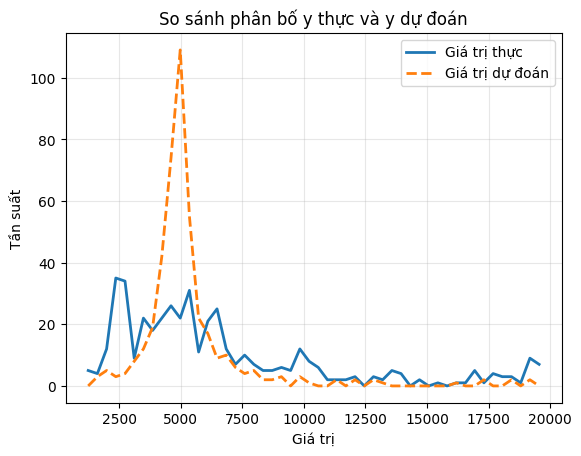

------------------------------------------------------------
SVR Config: Kernel=poly, C=1000, Eps=0.1, Test=0.2
Results: RMSE=3512.10, R2=0.436


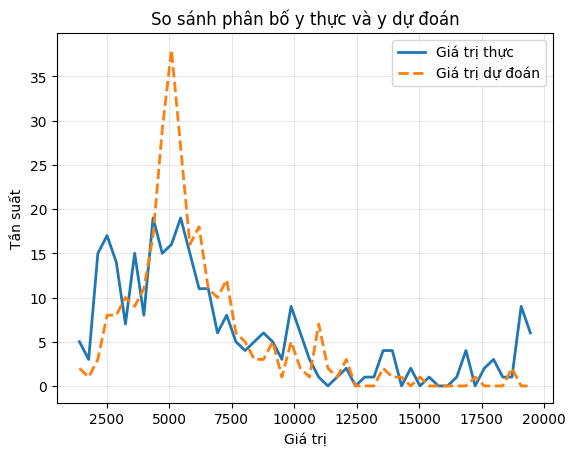

------------------------------------------------------------
SVR Config: Kernel=poly, C=1000, Eps=0.1, Test=0.3
Results: RMSE=3361.99, R2=0.441


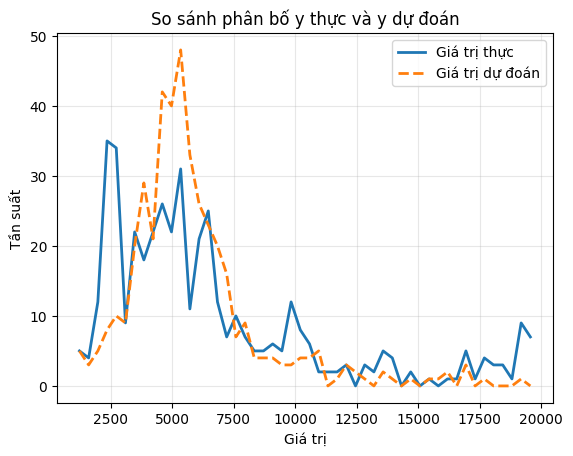

------------------------------------------------------------
SVR Config: Kernel=poly, C=1000, Eps=1, Test=0.2
Results: RMSE=3511.94, R2=0.436


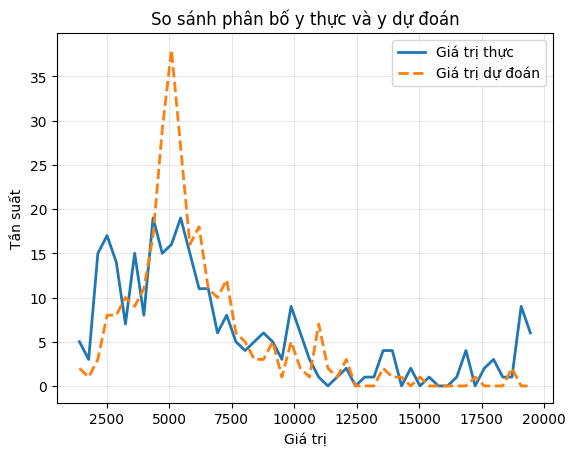

------------------------------------------------------------
SVR Config: Kernel=poly, C=1000, Eps=1, Test=0.3
Results: RMSE=3361.82, R2=0.441


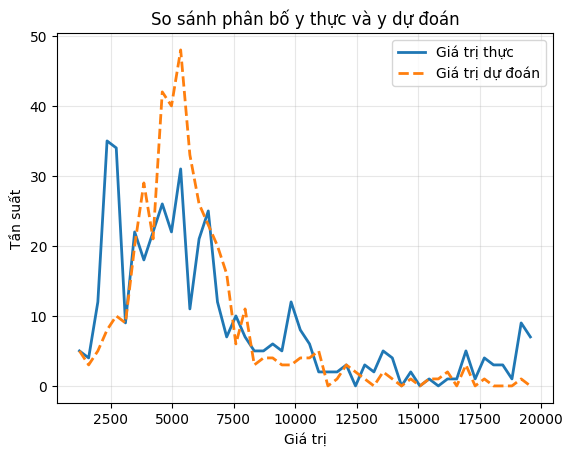

------------------------------------------------------------
SVR Config: Kernel=poly, C=1000, Eps=10, Test=0.2
Results: RMSE=3510.41, R2=0.436


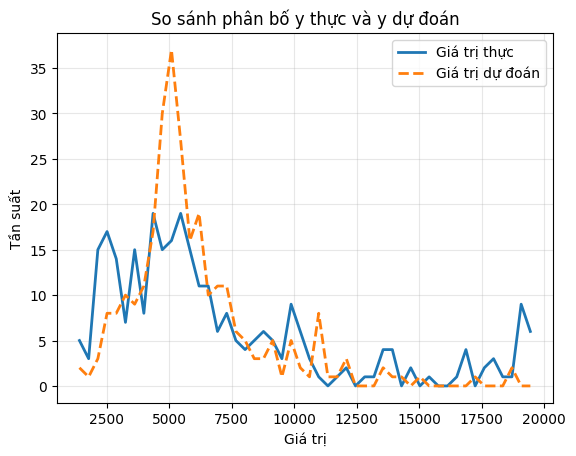

------------------------------------------------------------
SVR Config: Kernel=poly, C=1000, Eps=10, Test=0.3
Results: RMSE=3360.12, R2=0.442


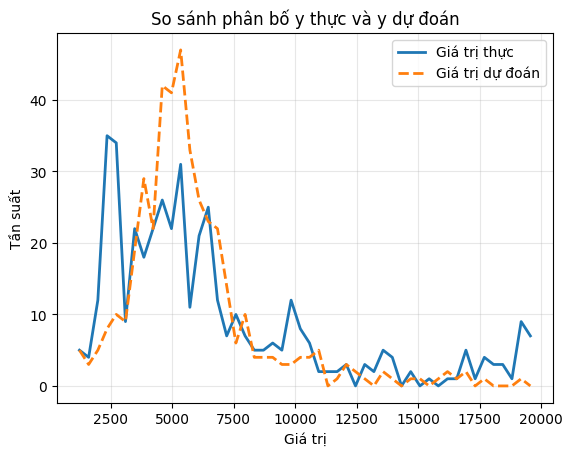

------------------------------------------------------------
SVR Config: Kernel=rbf, C=10, Eps=0.1, Test=0.2
Results: RMSE=4969.81, R2=-0.130


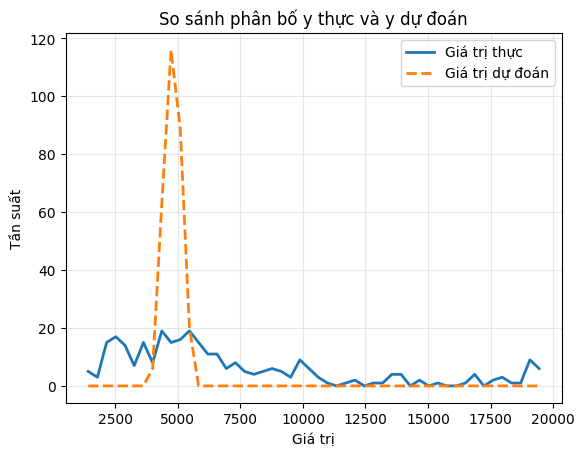

------------------------------------------------------------
SVR Config: Kernel=rbf, C=10, Eps=0.1, Test=0.3
Results: RMSE=4689.19, R2=-0.087


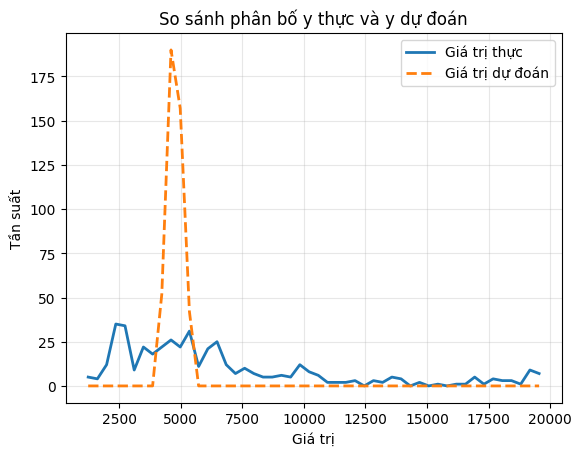

------------------------------------------------------------
SVR Config: Kernel=rbf, C=10, Eps=1, Test=0.2
Results: RMSE=4969.65, R2=-0.130


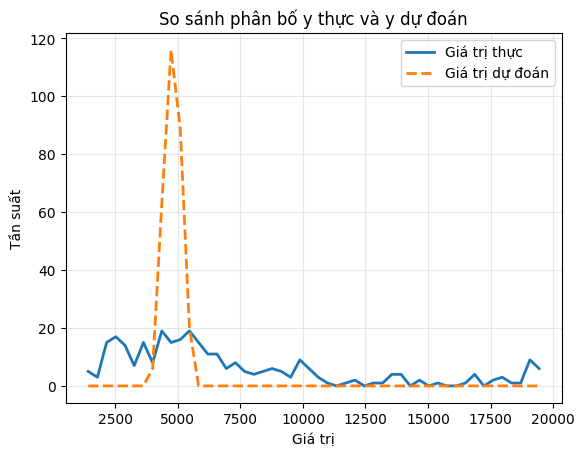

------------------------------------------------------------
SVR Config: Kernel=rbf, C=10, Eps=1, Test=0.3
Results: RMSE=4689.15, R2=-0.087


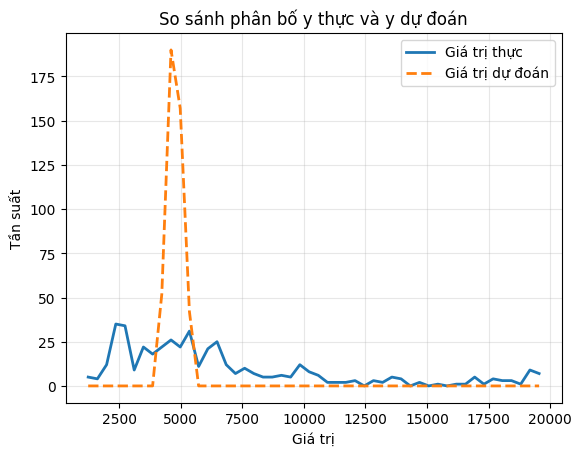

------------------------------------------------------------
SVR Config: Kernel=rbf, C=10, Eps=10, Test=0.2
Results: RMSE=4966.75, R2=-0.129


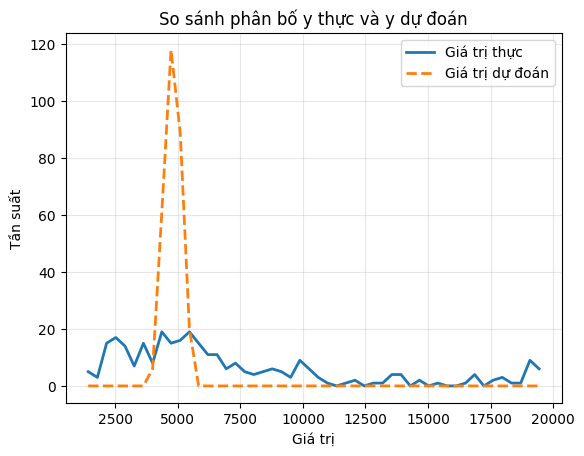

------------------------------------------------------------
SVR Config: Kernel=rbf, C=10, Eps=10, Test=0.3
Results: RMSE=4688.07, R2=-0.087


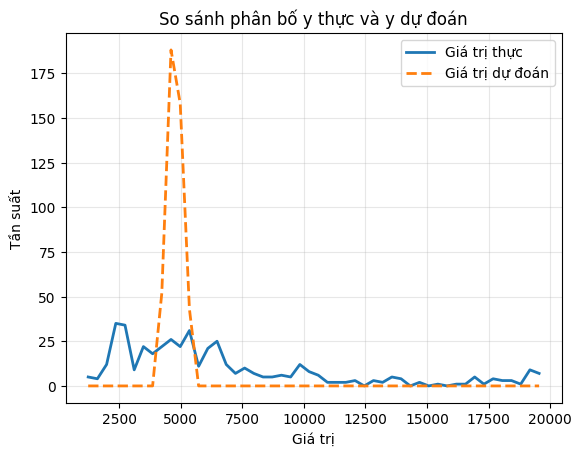

------------------------------------------------------------
SVR Config: Kernel=rbf, C=100, Eps=0.1, Test=0.2
Results: RMSE=3977.30, R2=0.276


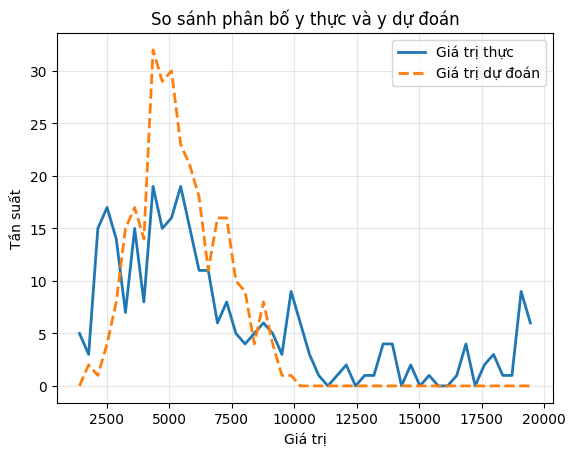

------------------------------------------------------------
SVR Config: Kernel=rbf, C=100, Eps=0.1, Test=0.3
Results: RMSE=3754.09, R2=0.303


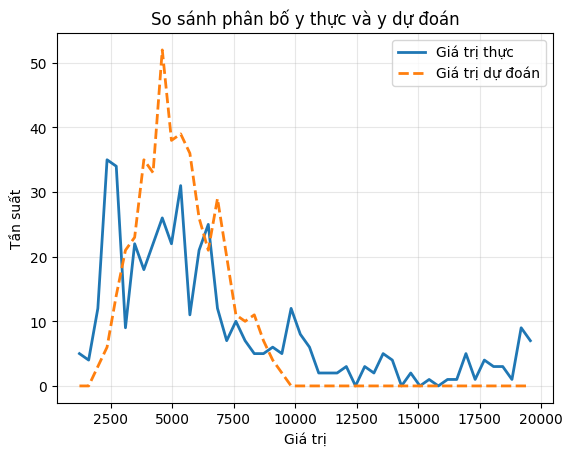

------------------------------------------------------------
SVR Config: Kernel=rbf, C=100, Eps=1, Test=0.2
Results: RMSE=3977.46, R2=0.276


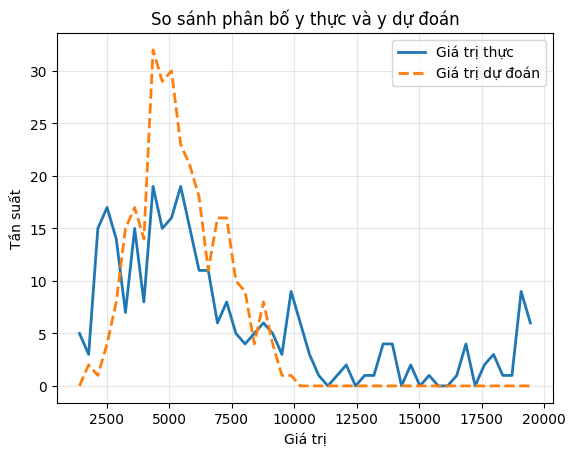

------------------------------------------------------------
SVR Config: Kernel=rbf, C=100, Eps=1, Test=0.3
Results: RMSE=3754.20, R2=0.303


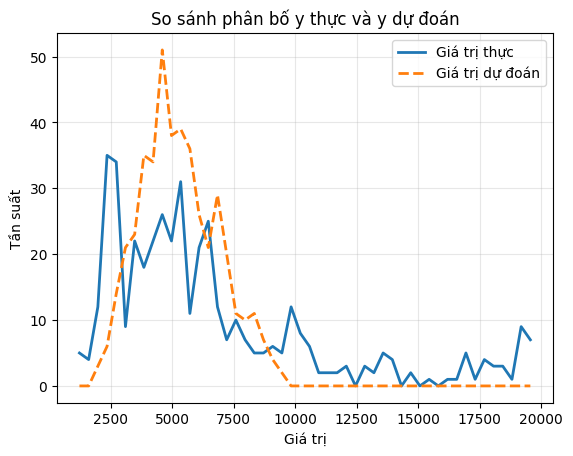

------------------------------------------------------------
SVR Config: Kernel=rbf, C=100, Eps=10, Test=0.2
Results: RMSE=3980.31, R2=0.275


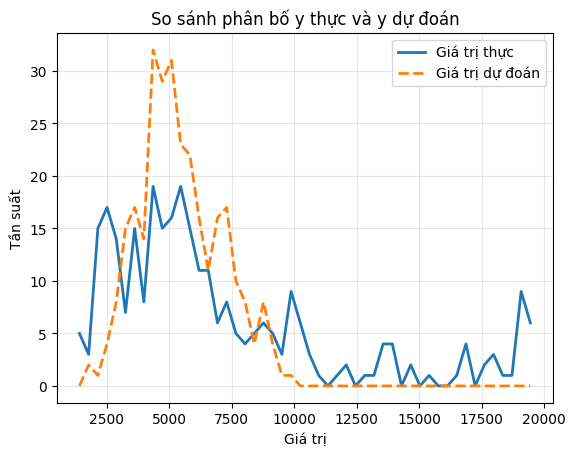

------------------------------------------------------------
SVR Config: Kernel=rbf, C=100, Eps=10, Test=0.3
Results: RMSE=3754.84, R2=0.303


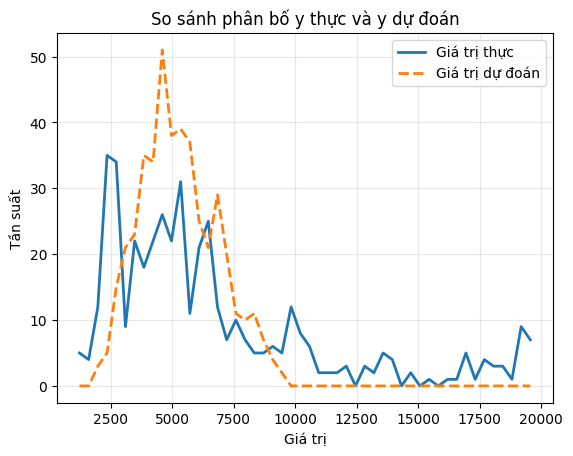

------------------------------------------------------------
SVR Config: Kernel=rbf, C=1000, Eps=0.1, Test=0.2
Results: RMSE=2978.54, R2=0.594


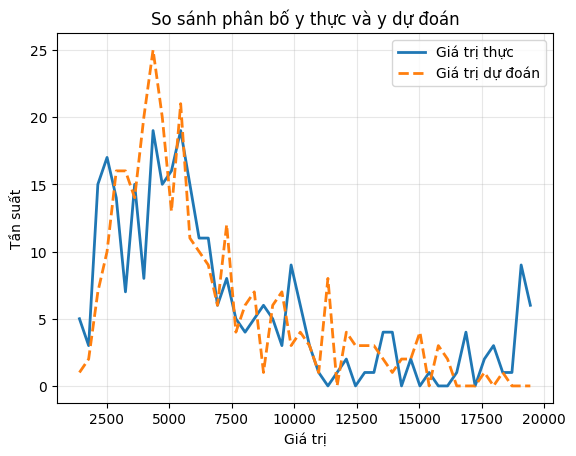

------------------------------------------------------------
SVR Config: Kernel=rbf, C=1000, Eps=0.1, Test=0.3
Results: RMSE=2745.73, R2=0.627


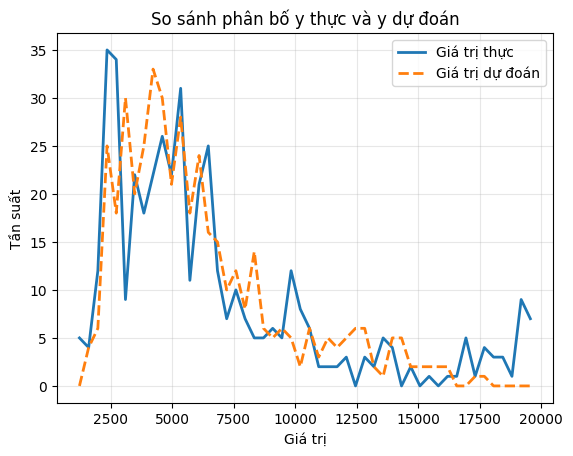

------------------------------------------------------------
SVR Config: Kernel=rbf, C=1000, Eps=1, Test=0.2
Results: RMSE=2978.55, R2=0.594


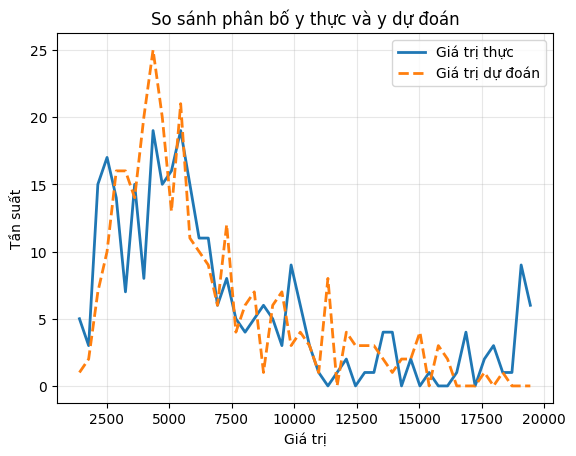

------------------------------------------------------------
SVR Config: Kernel=rbf, C=1000, Eps=1, Test=0.3
Results: RMSE=2745.67, R2=0.627


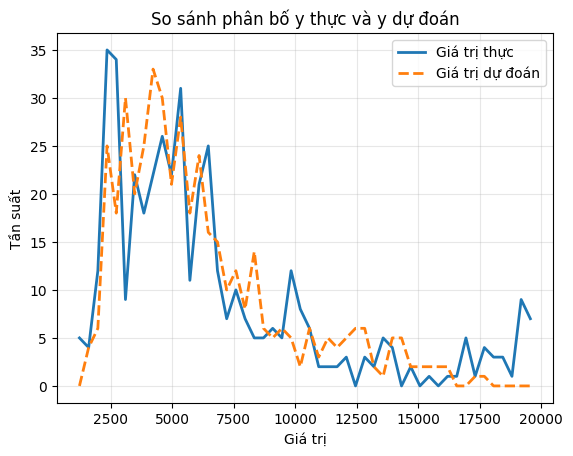

------------------------------------------------------------
SVR Config: Kernel=rbf, C=1000, Eps=10, Test=0.2
Results: RMSE=2978.63, R2=0.594


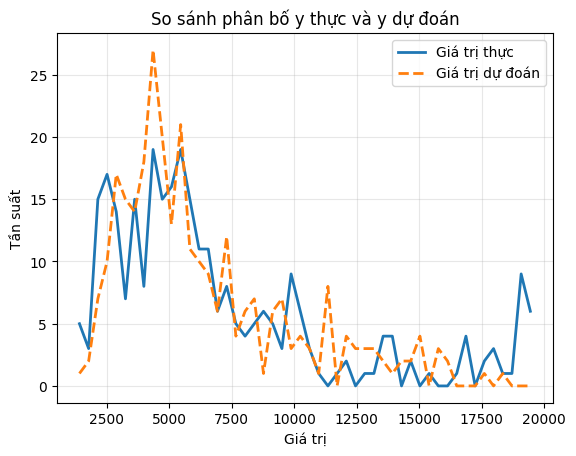

------------------------------------------------------------
SVR Config: Kernel=rbf, C=1000, Eps=10, Test=0.3
Results: RMSE=2745.43, R2=0.627


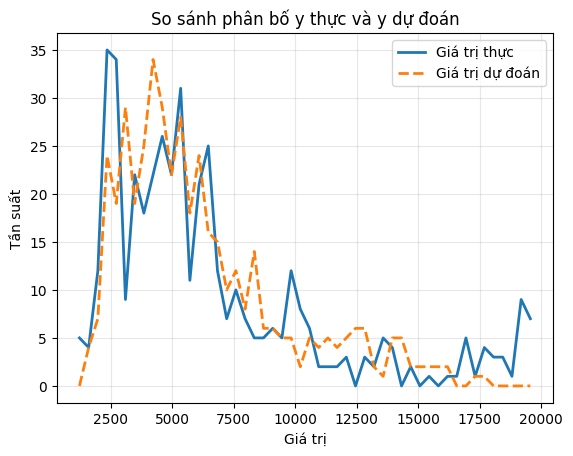

In [12]:
results_list_2 = validate_svr(X=X_encode, y=y_origin, reduce=True)

In [13]:
df_3 = pd.DataFrame(results_list_2) 

In [14]:
df_3

Kernel     C  Epsilon  Test_Size          MAE         RMSE        R2
0   linear    10      0.1        0.2  2187.050635  2948.274616  0.602280
1   linear    10      0.1        0.3  2046.433556  2804.628384  0.611085
2   linear    10      1.0        0.2  2187.073162  2948.415807  0.602242
3   linear    10      1.0        0.3  2046.518027  2804.775888  0.611044
4   linear    10     10.0        0.2  2187.258119  2948.601059  0.602192
5   linear    10     10.0        0.3  2046.407853  2804.889384  0.611012
6   linear   100      0.1        0.2  2188.137689  2893.415738  0.616944
7   linear   100      0.1        0.3  2044.443044  2741.719208  0.628336
8   linear   100      1.0        0.2  2188.031192  2893.360087  0.616958
9   linear   100      1.0        0.3  2044.496120  2741.837135  0.628304
10  linear   100     10.0        0.2  2187.751323  2894.026578  0.616782
11  linear   100     10.0        0.3  2044.962545  2741.860728  0.628298
12  linear  1000      0.1        0.2  2188.146253  2890.308574  0.617766
13  linear  1000      0.1        0.3  2048.275541  2737.560263  0.629463
14  linear  1000      1.0        0.2  2188.176701  2890.362655  0.617752
15  linear  1000      1.0        0.3  2048.333083  2737.631403  0.629444
16  linear  1000     10.0        0.2  2188.420843  2891.002795  0.617582
17  linear  1000     10.0        0.3  2047.920056  2737.432511  0.629497
18    poly    10      0.1        0.2  2986.709333  4494.976487  0.075523
19    poly    10      0.1        0.3  2848.561432  4318.469741  0.077929
20    poly    10      1.0        0.2  2986.709333  4494.976487  0.075523
21    poly    10      1.0        0.3  2848.379799  4318.111714  0.078082
22    poly    10     10.0        0.2  2986.556623  4494.783274  0.075603
23    poly    10     10.0        0.3  2847.127478  4315.566541  0.079169
24    poly   100      0.1        0.2  2468.690851  3743.779884  0.358699
25    poly   100      0.1        0.3  2333.929601  3603.384122  0.358014
26    poly   100      1.0        0.2  2468.686663  3743.747485  0.358710
27    poly   100      1.0        0.3  2333.905522  3603.336620  0.358031
28    poly   100     10.0        0.2  2468.426184  3743.221676  0.358891
29    poly   100     10.0        0.3  2333.436512  3602.402725  0.358364
30    poly  1000      0.1        0.2  2320.958568  3512.098850  0.435616
31    poly  1000      0.1        0.3  2198.946680  3361.994173  0.441146
32    poly  1000      1.0        0.2  2320.932116  3511.938467  0.435668
33    poly  1000      1.0        0.3  2198.870781  3361.818457  0.441204
34    poly  1000     10.0        0.2  2320.642723  3510.411257  0.436158
35    poly  1000     10.0        0.3  2198.140976  3360.119756  0.441769
36     rbf    10      0.1        0.2  3232.156727  4969.810599 -0.130110
37     rbf    10      0.1        0.3  3041.109212  4689.186392 -0.087175
38     rbf    10      1.0        0.2  3232.056457  4969.650388 -0.130037
39     rbf    10      1.0        0.3  3041.114074  4689.153967 -0.087160
40     rbf    10     10.0        0.2  3230.267802  4966.749171 -0.128718
41     rbf    10     10.0        0.3  3040.731604  4688.067560 -0.086656
42     rbf   100      0.1        0.2  2622.365875  3977.297218  0.276202
43     rbf   100      0.1        0.3  2443.716413  3754.086820  0.303192
44     rbf   100      1.0        0.2  2622.454967  3977.459771  0.276143
45     rbf   100      1.0        0.3  2443.772013  3754.203315  0.303149
46     rbf   100     10.0        0.2  2623.898718  3980.310527  0.275105
47     rbf   100     10.0        0.3  2444.156187  3754.839473  0.302913
48     rbf  1000      0.1        0.2  2215.568887  2978.537481  0.594074
49     rbf  1000      0.1        0.3  2010.395944  2745.725016  0.627249
50     rbf  1000      1.0        0.2  2215.556293  2978.545351  0.594072
51     rbf  1000      1.0        0.3  2010.406909  2745.671299  0.627264
52     rbf  1000     10.0        0.2  2215.550186  2978.631686  0.594048
53     rbf  1000     10.0        0.3  2010.584559  2745.426940

Nhận xét:
- Hiệu năng tổng thể sụt giảm đáng kể: So với kết quả trên dữ liệu gốc (chưa giảm chiều) có thể đạt chỉ số R^2 = 0.93, kết quả trên dữ liệu đã giảm chiều lại thấp hơn rất nhiều:
    - Chỉ số R^2 cao nhất chỉ đạt khoảng 0.629 (ở Kernel Linear và RBF với C=1000).
    - Điều này cho thấy việc giảm từ 43 đặc trưng xuống 14 đặc trưng đã làm mất đi một lượng lớn thông tin quan trọng cần thiết để giải thích sự biến động của thu nhập (Monthly Income).

- Sự khác biệt giữa các Kernel:
    - Kernel Linear: Vẫn là mô hình ổn định nhất. Ngay cả với C nhỏ (C=10), nó vẫn đạt được R^2 trên 0.60. Điều này chứng tỏ mối quan hệ giữa các thành phần chính (PCA components) và thu nhập mang tính tuyến tính rõ rệt.
    - Kernel RBF: Rất nhạy cảm với tham số C: Ở C=10, mô hình cho kết quả cực kỳ tệ (R^2 < 0), nghĩa là dự báo còn kém hơn cả việc lấy giá trị trung bình, chỉ khi tăng C lên 1000, RBF mới bắt đầu cho kết quả tương đương với Linear (R^2 = 0.627).
    - Kernel Poly: Cho kết quả kém nhất trong cả 3 loại. Chỉ số R^2 dao động từ 0.07 đến 0.44. Điều này cho thấy hàm đa thức không phù hợp để mô hình hóa dữ liệu sau khi đã qua biến đổi PCA trong bài toán này.
    
- Vai trò tham số C: đối với dữ liệu đã giảm chiều, mô hình cần một giá trị C lớn (1000) để có thể học được dữ liệu tốt hơn. Khi C nhỏ, mô hình bị hiện tượng Underfitting.

- Kết luận về việc giảm chiều (PCA):
    - Ưu điểm: Giúp mô hình chạy nhanh hơn và đơn giản hóa tập dữ liệu (chỉ còn 14 chiều).
    - Nhược điểm: Việc giảm chiều trong trường hợp này gây tổn thất độ chính xác nghiêm trọng (giảm R^2 từ 0.93 xuống còn 0.63).

